In [6]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import (
    confusion_matrix,
    roc_curve, auc,
    precision_recall_curve,
    precision_score, recall_score, f1_score,accuracy_score,
    classification_report,
    ConfusionMatrixDisplay
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict

<h2 style="text-align: center;">Instituto Superior de Engenharia de Lisboa</h2>  
<h3 style="text-align: center;">Licenciatura em Engenharia Informática e Multimédia</h3>
<p  style="margin-top:20px;text-align: center;">Aprendizagem Automática</p>
<p  style="text-align: center;">Semestre de Inverno 2024/2025</p>
<p  style="text-align: center;">1º Trabalho Prático</p>
<p  style="text-align: center;">Trabalho realizado por: </p>
<div style="margin:auto; display:flex"> 
    <ul style="margin:auto; display:block">
        <li>Alice Fernandes, Aluna Nº 45741</li>
        <li>Guilherme Mendes, Aluno Nº  49718</li>
        <li>Bruno Antunes, Aluno Nº 49755</li>
    </ul>
</div>

# Indíce
1. [Indíce de Figuras](#1---Indíce-de-Figuras)
2. [Introdução](#2---Introdução)
3. [Desenvolvimento](#3---Desenvolvimento)
4. [Conclusão](#4---Conclusão)
5. [Bibliografia](#5---Bibliografia)

# 1 - Introdução

A diabetes é uma doença crónica que afeta milhões de pessoas em todo o mundo, caracterizada por níveis elevados de glicose no sangue. O diagnóstico precoce e preciso desta condição é fundamental para prevenir complicações graves e melhorar a qualidade de vida dos pacientes.

Para este trabalho, vamos usar o _dataset_ Pima Diabetes, criado pelo National Institute of Diabetes and Digestive and Kidney Diseases (EUA), que contém informação sobre 768 mulheres da população indígena Pima, uma população com elevada incidência de diabetes. O _dataset_ inclui 500 mulheres sem diabetes e 268 mulheres com diabetes, sendo cada observação caracterizada pelos seguintes atributos: 
- número de gravidezes, 
- concentração de glicose plasmática, 
- pressão arterial diastólica, 
- espessura da dobra cutânea do tríceps, 
- nível sérico de insulina, 
- índice de massa corporal, 
- Diabetes Pedigree Function,
- Idade

O objetivo deste trabalho é desenvolver e comparar diferentes modelos de classificação binária capazes de determinar se um paciente apresenta diabetes com base nas características. Para tal, serão implementados e avaliados três classificadores, sendo um deles obrigatoriamente o Random Forest, utilizando metodologias adequadas de treino/teste e métricas apropriadas para avaliar o desempenho dos modelos.

Adicionalmente, será investigado o impacto da normalização dos dados no desempenho dos classificadores, analisando se a transformação dos dados para média nula e variância unitária contribui para melhorar a capacidade preditiva dos modelos.

O relatório apresenta uma análise dos resultados obtidos, justificando as escolhas realizadas e discutindo as decisões tomadas ao longo do desenvolvimento do trabalho.


# 3 - Desenvolvimento

Para este trabalho, foram selecionados 2 classificadores binários para a tarefa de classificação. O _Random Forest Classifier_ é um classificador obrigatório, baseado em ensemble de árvores de decisão. O _Support Vector Classifier (SVC)_ é um algoritmo baseado em máquinas de vetores de suporte com diferentes kernels. A _Logistic Regression_ é um modelo linear interpretável que utiliza a função logística.

Vamos também encontrar os melhores parametros para cada classificador, e garantir que a proporção das classes é mantida nos conjuntos de teste e de treino.

Para avaliar o desempenho dos classificadores, serão utilizadas várias métricas, incluindo a Matriz de Confusão, Precision, Recall e F1-Score, bem como as Curvas ROC e Precision-Recall. A avaliação será realizada tanto no conjunto de treino quanto no conjunto de teste para detetar possível overfitting. Será também investigado o impacto da normalização dos dados no desempenho dos classificadores.

## 3.1 - Carregamento e Análise Inicial dos Dados

Nesta secção, vamos carregar e analisar o dataset, para tentarmos perceber a estrutura dos dados e a distribuição das classes.

O dataset é um problema de classificação binária onde:
- **Classe 0**: Paciente **não** tem diabetes (classe negativa)
- **Classe 1**: Paciente **tem** diabetes (classe positiva)

A variável `y` contém os _labels_ das classes (0 ou 1) para cada amostra, enquanto `X` contém os dados com 8 atributos por cada amostra.


In [5]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

# Carregar dados
data = pickle.load(open("pimaDiabetes.p", "rb"))
X = data['data']
y = data['target']

print(f"Shape de X (features): {X.shape}")
print(f"Shape de y (target): {y.shape}")
print(f"\nNúmero total de amostras: {len(y)}")
print(f"Número de features: {X.shape[1]}")
print("\nClasses do dataset:")
print(f"  - Classe 0 (sem diabetes): {np.sum(y==0)} amostras ({ np.round(np.sum(y==0)/len(y)*100) }%)")
print(f"  - Classe 1 (com diabetes): {np.sum(y==1)} amostras ({ np.round(np.sum(y==1)/len(y)*100) }%)")


Shape de X (features): (768, 8)
Shape de y (target): (768,)

Número total de amostras: 768
Número de features: 8

Classes do dataset:
  - Classe 0 (sem diabetes): 500 amostras (65.0%)
  - Classe 1 (com diabetes): 268 amostras (35.0%)


O dataset apresenta um desequilíbrio entre as classes (65% vs 35%), com mais amostras da classe 0 (sem diabetes) do que da classe 1 (com diabetes). Para garantir a mesma proporção os conjuntos de teste e validação, vamos então o usar o parametro _stratify_ para manter a mesma percentagem nos conjuntos. Este parametro é essencial para obter o melhor desempenho dos classificadores, especialmente para detectar amostras com a classe 1, que é a que tem menos representação no conjunto de dados.

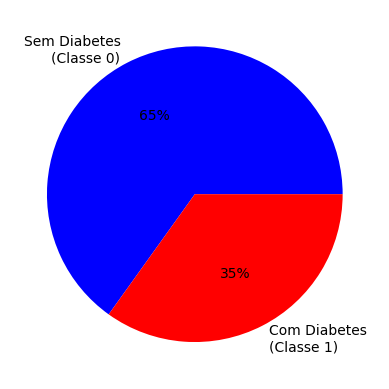

In [7]:
# Dados
classes = ['Sem Diabetes\n(Classe 0)', 'Com Diabetes\n(Classe 1)']
counts = [np.sum(y==0), np.sum(y==1)]
colors = ['blue', 'red']
# Gráfico de pizza
plt.pie(counts, labels=classes, colors=colors, autopct='%1.0f%%')

plt.show()

## 3.2 - Treino de Classificadores

Nesta secção vamos então treinar e avaliar três classificadores binários: `SVC`, `Random Forest Classifier` e `Logistic Regression`. 

Para a divisão dos dados, vamos dividir 70% para treino e 30% para teste, com estratificação para manter a proporção de classes em ambos os conjuntos. Esta divisão resulta 512 amostras para treino/validação e 256 amostras para teste.

A calibração dos hiperparâmetros de cada modelo será feita utilizando `GridSearchCV` com validação cruzada estratificada _StratifiedKFold_ com 5 _folds_ (este tipo de K-Fold mantêm a mesma distribuição de classes nos conjuntos). Esta abordagem permite-nos encontrar o melhor conjunto de hiperparametros.

Adicionalmente, para cada classificador, iremos também encontrar o melhor limiar de decisão utilizando validação cruzada. Em vez de usar o limiar de omissão, vamos testar vários limiares (entre 0 e 1) para encontrar aquele que obtém a melhor taxa de verdadeiros positivos, e minimiza os falsos positivos. Para isso, vamos usar a métrica `F1-Score`, que combina as métricas de `precision` e `recall` num único valor. O limiar usado pelo `scikit-learn` nos modelos de classificação binária é 0.5, que pode não ser o mais adequado para os dados que estamos a avaliar.

Para encontrar o limiar de decisão, vamos usar `cross_val_predict`, que treina modelos em cada _fold_ e prevê nas amostras de validação. O limiar encontrado é então aplicado ao conjunto de teste para avaliação final.

### 3.2.1 Métricas de Avaliação

Para avaliar o desempenho dos classificadores, utilizamos várias métricas complementares:

- Matriz de Confusão: Tabela que resume as previsões do modelo, mostrando os Verdadeiros Positivos (TP), Verdadeiros Negativos (TN), Falsos Positivos (FP) e Falsos Negativos (FN). Esta matriz permite visualizar onde o modelo está a acertar e a errar, e é útil para identificar se o modelo está a confundir mais frequentemente a classe positiva com a negativa ou vice-versa.

- _Precision_: É uma métrica que ajuda a perceber se o modelo está a acertar corretamente na classificação das classes. É calculada como $\frac{TP}{TP+FP}$. Uma precisão alta indica que quando o modelo prevê diabetes, é provável que esteja correto. Esta métrica é importante quando o custo de um falso positivo é elevado (diagnosticar diabetes quando não existe).

- _Recall_: Esta métrica ajuda a perceber se o modelo consegue detetar todos os casos positivo. É calculada como  $\frac{TP}{TP+FN}$. Um _recall_ alto indica que o modelo consegue detetar a maioria dos casos de diabetes. Esta métrica é importante em problemas de classificação em que falsos negativos podem ter consequencias ao nivel do tratamento(deteção de diabetes quando o paciente não tem diabetes).

- _F1-Score_: É uma métrica que combina as métricas precision e recall. É calculada como $2 \times \frac{precision \times recall }{precision + recall }$.  Esta métrica dá mais importancia a valores baixos, e se a precision e o recall tiverem baixos indica que o nosso modelo não está a dar os melhores resultados.

- _Curva ROC_: Gráfico que mostra a relação entre e o Recall e Falsos Positivos (FP) para vários limiares. A área sob a curva ROC (AUC) varia entre 0 e 1, onde valores próximos de 1 indicam melhor capacidade do modelo discriminar entre classes. Esta curva permite-nos o desempenho de vários limiares, e perceber se o limiar usado é o melhor ou não.

_Curva Precision-Recall_: Gráfico que mostra a relação entre precision e recall para vários limiares. Esta curva foca-se no desempenho da classe positiva (diabetes), ao contrário da curva ROC que nos dá uma visão geral de como os vários limiares se comportam na classificação.

A avaliação será realizada tanto no conjunto de treino quanto no conjunto de teste para evitar o `overfitting` e garantir a capacidade de generalização dos modelos.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3,stratify=y)
cv = StratifiedKFold(n_splits=5) # para o grid search mais tarde

In [9]:
# Funções utilitárias para os classificadores

# Plota duas matrizes de confusão lado a lado (treino e teste).
def plot_confusion_matrices(cm_train, cm_test, title_prefix):
    fig, axes = plt.subplots(1, 2, figsize=(9, 3))
    
    # Treino
    disp_train = ConfusionMatrixDisplay(cm_train)
    disp_train.plot(ax=axes[0], cmap="Blues", colorbar=False)
    axes[0].set_title(f'{title_prefix} - Treino')
    
    # Teste
    disp_test = ConfusionMatrixDisplay(cm_test)
    disp_test.plot(ax=axes[1], cmap="Blues", colorbar=False)
    axes[1].set_title(f'{title_prefix} - Teste')
    
    plt.tight_layout()
    plt.show()

# Plota curva ROC (suporta plots fora e dentro de subplots)
def plot_roc_curve(fpr, tpr, roc_auc, threshold_point, model_name, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 4))
    
    ax.plot(fpr, tpr, color='blue', label='Curva ROC')
    
    ax.scatter(threshold_point[0], threshold_point[1], color='red', label='Limiar',)# Coloca o ponto do limiar a vermelho
    
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'Curva ROC - {model_name}')
    ax.legend()
    ax.axis("scaled")
    ax.grid(True)
    
    if ax is None:
        plt.tight_layout()

def plot_precision_recall_curve(recall_vals, precision_vals, threshold_point, model_name, ax=None):
    ax.plot(recall_vals, precision_vals, color='green', label='Curva Precision-Recall')
    
    ax.scatter(threshold_point[0], threshold_point[1], color='red', label='Limiar',)
  
        
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title(f'Curva Precision-Recall - {model_name}')
    ax.legend()
    ax.axis("scaled")
    
    ax.grid(True)
    
    if ax is None:
        plt.tight_layout()
        plt.show()

def find_threshold(model, X_train, y_train, cv, param_grid=None):
    # Obter probabilidades previstas usando validação cruzada
    model.set_params(**param_grid) # aplicar parametros ao modelo
    
    y_train_proba_cv = cross_val_predict(
        model,
        X_train, 
        y_train,
        cv=cv,
        method='predict_proba'
    )[:, 1]
    
    # Testar diferentes limiares (de 0,1, 50 valores)
    threshold_candidates = np.linspace(0, 1, 50)
    f1_scores = []
    
    for threshold in threshold_candidates:
        y_pred_thresh = (y_train_proba_cv >= threshold).astype(int)
        f1_scores.append(f1_score(y_train, y_pred_thresh))
    
    # Encontrar o melhor limiar
    best_threshold_idx = np.argmax(f1_scores)
    best_threshold = threshold_candidates[best_threshold_idx]
    best_f1 = f1_scores[best_threshold_idx]
    
    return best_threshold, best_f1, f1_scores

# Plota todos os gráficos num subplot
def plot_threshold_analysis(fpr, tpr, roc_auc, recall_vals, precision_vals, cm_threshold, threshold_point_roc, threshold_point_pr, model_name=''):
    fig, axes = plt.subplots(1, 3, figsize=(14, 4))
    plot_roc_curve(fpr, tpr, roc_auc, threshold_point_roc, model_name, ax=axes[0])
    plot_precision_recall_curve(recall_vals, precision_vals, threshold_point_pr, model_name, ax=axes[1])
    
    # Matriz de confusão com limiar otimizado    
    disp_threshold = ConfusionMatrixDisplay(cm_threshold)    
    disp_threshold.plot(ax=axes[2], cmap='Blues')    
    axes[2].set_title('Confusion Matrix')
    
    plt.tight_layout()
    plt.axis("scaled")
    
    plt.show()


def plot_CF(cm_1, cm_2, title_prefix1, title_prefix2):
    fig, axes = plt.subplots(1, 2, figsize=(12, 3))
    
    # Mostra matriz de confusão 1, com o titlo desejado, title_prefix1
    disp_train = ConfusionMatrixDisplay(cm_1)
    disp_train.plot(ax=axes[0], cmap="Blues", colorbar=False)
    axes[0].set_title(f'{title_prefix1}')
    
    # Mostra matriz de confusão 2, com o titlo desejado, title_prefix2
    disp_test = ConfusionMatrixDisplay(cm_2)
    disp_test.plot(ax=axes[1], cmap="Blues", colorbar=False)
    axes[1].set_title(f'{title_prefix2}')
    
    plt.tight_layout()
    plt.show()

### 3.2.1 - SVC 

O primeiro classificador que vamos treinar é o SVC. O SVC, ou Support Vector Classifier, é um classificador baseado no SVM, no sentido em que tenta identificar um hiperplano que separe as classes da forma mais eficaz possível. Este classificador tenta maximizar a margem entre os grupos, ou seja, garantir que a fronteira fica posicionada de modo a aumentar a separação entre os pontos mais próximos de cada classe. 

Isto acaba por tornar o modelo mais estável e menos sensível a pequenas variações nos dados. Quando a separação linear não é viável, recorre-se aos kernels, que permitem mapear os dados para um espaço de maior dimensão onde essa fronteira se torna mais clara e mais fácil de definir.

#### Parametros testados

Para este modelo, escolhemos usar os seguintes parametros. Tentámos balancear os parametros de modo a que a pesquisa de hiperparâmetros não demorasse muito tempo, e colocar várias opções de teste de modo a encontrar um bom conjunto de parametros.

- _kernel_: Algoritmo que define a forma da fronteira de decisão: _linear_ é uma fronteira no formato de uma reta, enquanto _rbf_ e _sigmoid_  permitem fronteiras mais complexas quando os dados não são possiveis de separa com uma fronteira linear
- _C_: Valor de penalização para erros de classificação. Valores baixos tornam o modelo mais tolerante ao erro, valores altos podem fazer com que o modelo entre em sobre-aprendizagem.
- _gamma_: Ajusta o "detalhe" da fronteira de decisão para _kernels_ não lineares. Valores altos permitem fronteiras muito detalhadas, valores baixos fazem com que as fronteiras fiquem mais "suaves" e generalizáveis.

Outros parametros que também testamos foi uma fronteira polinomial (_poly_) e um parametro que tinha em conta a percentagem de cada classe (_class-weight_), mas devido à pesquisa demorar a convergir, ficamos apenas com os 3 parametros descritos acima em detalhe.



Desempenho no conjunto de Treino
              precision    recall  f1-score   support

           0       0.76      0.93      0.84       333
           1       0.79      0.45      0.57       179

    accuracy                           0.77       512
   macro avg       0.77      0.69      0.71       512
weighted avg       0.77      0.77      0.75       512


Desempenho no conjunto de Teste
              precision    recall  f1-score   support

           0       0.78      0.92      0.84       167
           1       0.77      0.52      0.62        89

    accuracy                           0.78       256
   macro avg       0.77      0.72      0.73       256
weighted avg       0.78      0.78      0.76       256

Score dos dados de treino: 0.765625
Score dos dados de teste: 0.77734375


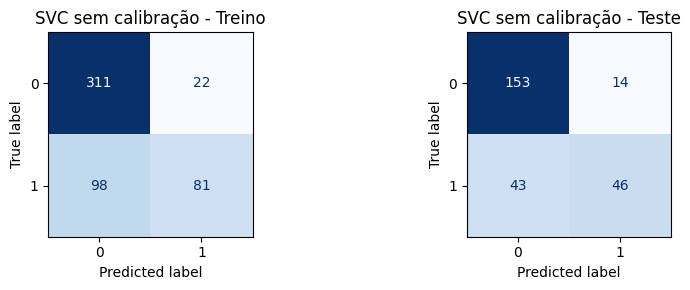

In [10]:
def svc_uncalibrated(X_train, y_train, X_test, y_test ):
    svc = SVC(probability=True, random_state=42, cache_size=1000).fit(X_train, y_train)
    
    # Previsões no conjunto de treino
    y_train_pred_cal = svc.predict(X_train)
    print("\nDesempenho no conjunto de Treino")
    print(classification_report(y_train, y_train_pred_cal))
    cm_train_cal = confusion_matrix(y_train, y_train_pred_cal)

    # Previsões no conjunto de teste
    y_test_pred_cal = svc.predict(X_test)
    print("\nDesempenho no conjunto de Teste")
    print(classification_report(y_test, y_test_pred_cal))
    cm_test_cal = confusion_matrix(y_test, y_test_pred_cal)

    print('Score dos dados de treino:', svc.score(X_train, y_train))
    print('Score dos dados de teste:', svc.score(X_test, y_test))

    plot_confusion_matrices(cm_train_cal, cm_test_cal, 'SVC sem calibração')
    return cm_test_cal
    

svc_uncalibrated_cm = svc_uncalibrated(X_train, y_train, X_test, y_test)

In [ ]:
# Definir os hiperparâmetros
# https://stackoverflow.com/questions/72101295/python-gridsearchcv-taking-too-long-to-finish-running

def calibrate_svc(param_grid_svc, X_dataset,y_dataset, cv):
    grid_search_svc = GridSearchCV(
    estimator=SVC(probability=True, random_state=42, cache_size=1000), # aumentar o cache size
        param_grid=param_grid_svc,
        cv=cv,
        n_jobs=-1, #-1 é para usar todos os cores em processamento paralelo
    )

    # Treinar o modelo com GridSearchCV
    grid_search_svc.fit(X_dataset, y_dataset)  
    print(grid_search_svc.best_params_)

    # Usar o melhor modelo encontrado
    return grid_search_svc.best_estimator_, grid_search_svc.best_params_

# Conjunto rápido para correr
param_grid_svc1 = {
    'kernel': ['linear', 'sigmoid'],
}

# Testar multiplos params
# Resultado: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'} - 7m56s
param_grid_svc2 = {
    'C': [0.5, 1, 5,  10, 1000],
    'kernel': ['linear', 'rbf', 'sigmoid'],
    'gamma': ['scale', 1, 0.1, 0.01, 0.001,],
}

# Testar multiplos params
# Resultado: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'} - 11m56s
param_grid_svc3 = {
    'kernel': ['linear', 'rbf', 'sigmoid'],
    'C': [0.1, 1, 5, 10, 100],
    'gamma': ['scale', 0.1, 0.01, 0.001],
    'class_weight': [None, 'balanced'],
}

# Resultado: Este não convergiu em tempo util
param_grid_svc4 = {
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'C': [0.1, 1, 5, 10,20,50, 100,1000],
    'gamma': ['scale',1, 0.1, 0.01, 0.001],
    'degree': [3], # só usado quando kernel='poly', acima de 3 aumenta risco de overfitting
    # 'class_weight': [None, 'balanced'],
}

# Resultado: {'C': 5, 'gamma': 'scale', 'kernel': 'linear'} - 17m6s
param_grid_svc = {
    'kernel': ['linear', 'rbf', 'sigmoid'],
    'C': [0.1, 1, 5, 10,20,50, 100],
    'gamma': ['scale',1, 0.1, 0.01, 0.001],
}

# (Alice) Comentário para não me enganar a correr isto e esperar outros 30m - Retirar antes de entregar
svc_calibrated, svc_best_params = calibrate_svc(param_grid_svc,X_train,y_train, cv)

{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}



Desempenho no conjunto de Treino
              precision    recall  f1-score   support

           0       0.78      0.92      0.84       333
           1       0.78      0.51      0.62       179

    accuracy                           0.78       512
   macro avg       0.78      0.72      0.73       512
weighted avg       0.78      0.78      0.77       512


Desempenho no conjunto de Teste
              precision    recall  f1-score   support

           0       0.77      0.90      0.83       167
           1       0.72      0.49      0.59        89

    accuracy                           0.76       256
   macro avg       0.75      0.70      0.71       256
weighted avg       0.75      0.76      0.74       256



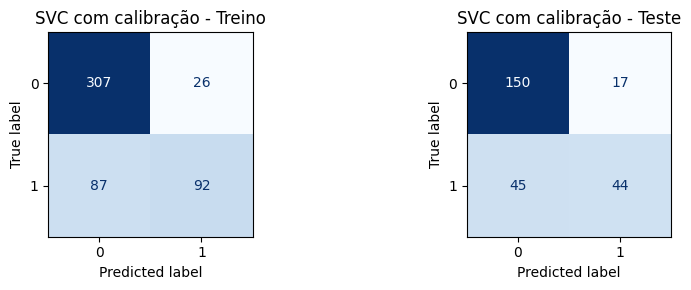

In [12]:
# Previsões no conjunto de treino
def predict_svc(svc_model, X_train,y_train,X_test,y_test ):
    y_train_pred_cal = svc_model.predict(X_train)
    print("\nDesempenho no conjunto de Treino")
    print(classification_report(y_train, y_train_pred_cal))
    cm_train_cal = confusion_matrix(y_train, y_train_pred_cal)

    # Previsões no conjunto de teste
    y_test_pred_cal = svc_model.predict(X_test)
    print("\nDesempenho no conjunto de Teste")
    print(classification_report(y_test, y_test_pred_cal))
    cm_test_cal = confusion_matrix(y_test, y_test_pred_cal)

    # Plotar matrizes de confusão usando a função
    plot_confusion_matrices(cm_train_cal, cm_test_cal, 'SVC com calibração')
    return cm_test_cal
    
    
svc_calibrated_cm = predict_svc(svc_calibrated, X_train,y_train,X_test,y_test)

Limiar (validação cruzada): 0.26530612244897955
F1-Score com limiar: 0.6407322654462243
F1-Scores: [0.5180897250361794, 0.5180897250361794, 0.518840579710145, 0.5195936139332366, 0.5272459499263623, 0.541033434650456, 0.5574803149606299, 0.5704918032786885, 0.5884413309982487, 0.6113207547169811, 0.6107784431137725, 0.6182572614107884, 0.6260869565217392, 0.6407322654462243, 0.6348448687350835, 0.6365914786967418, 0.6337662337662338, 0.6344086021505376, 0.6309859154929578, 0.6264367816091954, 0.6162790697674418, 0.6306306306306306, 0.6215384615384615, 0.5987261146496815, 0.6019417475728155, 0.5894039735099338, 0.5733788395904437, 0.563573883161512, 0.5454545454545454, 0.5428571428571428, 0.5239852398523985, 0.5019011406844106, 0.49411764705882355, 0.49606299212598426, 0.47580645161290325, 0.4380165289256198, 0.4351464435146444, 0.41702127659574467, 0.38427947598253276, 0.35714285714285715, 0.3287671232876712, 0.2571428571428571, 0.25, 0.18181818181818182, 0.13541666666666666, 0.0957446

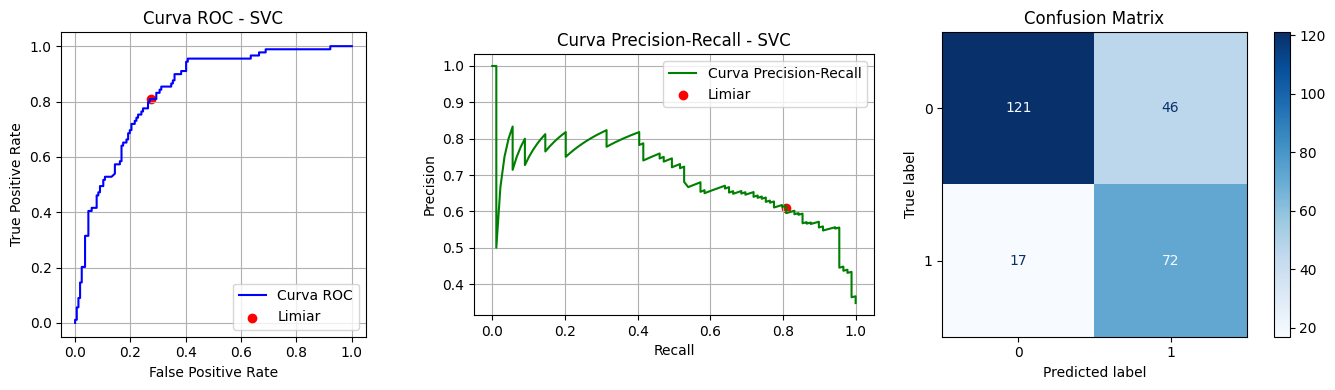

In [13]:
# Encontrar o limiar ótimo usando validação cruzada
def svc_with_threshold(X_train, y_train,X_test,y_test, cv,svc_best_params, svc_calibrated):
    best_threshold_f1, best_cv_f1, f1_scores = find_threshold(
        SVC(probability=True, random_state=42),
        X_train,
        y_train,
        cv,
        param_grid=svc_best_params
    )

    print(f"Limiar (validação cruzada): {best_threshold_f1}")
    print(f"F1-Score com limiar: {best_cv_f1}")
    print(f"F1-Scores: {f1_scores}")

    # Obter probabilidades no conjunto de teste e aplicar novo limiar apenas á classe positiva
    y_test_proba = svc_calibrated.predict_proba(X_test)
    y_test_proba = y_test_proba[:,1] # Obtem as probabiliades da classe positiva
    y_test_pred_threshold = (y_test_proba >= best_threshold_f1).astype(int)

    print(f"\nDesempenho com limiar ({best_threshold_f1}):") # ISTO ESTÁ REPETIDO

    # Calcular curvas para visualização
    # fp -> false positive
    # tp -> true positive
    fp, tp, thresholds_roc = roc_curve(y_test, y_test_proba)
    roc_auc = auc(fp, tp)
    print("ROC AUC Score:", roc_auc)
    
    cr = classification_report(y_test, y_test_pred_threshold, output_dict=True)
    print(cr)

    precision_vals, recall_vals, thresholds_pr = precision_recall_curve(y_test, y_test_proba)

    # thresholds_pr - best_threshold_f1 calcula a distancia entre 2 arrays
    # retorna a distancia absoluta, e nós queremos o valor minimo, que seria o limiar mais próximo, com base no f1-score
    # np.argmin retorna o index do array correspondente a valor do array que tem a menor distancia
    idx_closest = np.argmin(np.abs(thresholds_pr - best_threshold_f1))

    cm_test = confusion_matrix(y_test, y_test_pred_threshold)

    # Calcular pontos para os gráficos com limiar calculado
    fp_threshold = cm_test[0, 1] / cm_test[0, :].sum()  # FP / (TN + FP)
    tp_threshold = cm_test[1, 1] / cm_test[1, :].sum()  # TP / (TP + FN)

    plot_threshold_analysis(
        fp, tp, roc_auc,
        recall_vals, precision_vals,
        cm_test,
        (fp_threshold, tp_threshold),
        (recall_vals[idx_closest], precision_vals[idx_closest]),
        'SVC',
    )
    
    return cm_test, fp, tp, roc_auc, recall_vals, precision_vals, cr

svc_calibrated_cm_thres, svc_fpr, svc_tpr, svc_roc_auc, svc_recall, svc_precision, svc_report = svc_with_threshold(X_train, y_train,X_test,y_test, cv,svc_best_params, svc_calibrated)

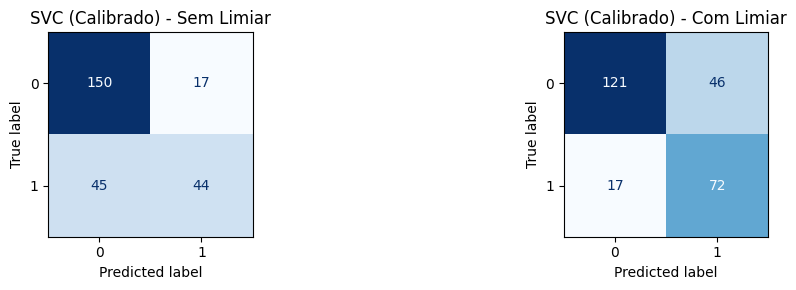

In [14]:
plot_CF(svc_calibrated_cm, svc_calibrated_cm_thres, 'SVC (Calibrado) - Sem Limiar', 'SVC (Calibrado) - Com Limiar')

Comparando as duas matrizes acima, SVC calibrado sem limiar e SVC calibrado com limiar, conseguimos observar como o limiar de decisão afeta os resultados da predição.

Sem alterar o limiar, o modelo usa o valor de omissão de 0.5 para decidir se a classe prevista é positiva ou negativa. O resultado é um classificador mais conservador na identificação da classe positiva, o que explica:
- Menos verdadeiros positivos
- Mais falsos negativos
- Boa capacidade de identificar negativos

Ou seja, o modelo é mais preciso a detectar a classe 0, mas falha uma parte significativa dos casos positivos.

Ao ajustar o limiar, o classificador torna-se mais fica mais sensível à classe dos positivos:
- Aumentam os verdadeiros positivos
- Diminuem os falsos negativos 
- Mas surgem mais falsos positivos

O ajuste do limiar aumenta o _recall_ do classificador mas acaba por detetar mais os casos positivos do que os negativos. Para a aplicação que temos, a redução dos falsos negativos acaba por ser uma boa melhoria porque não queremos falhar casos reais (quando o paciente tem diabetes, mas o classificador detecta na classe negativa).

### 3.2.2 - Random Forest Classifier (Gui)

#### TODO:
- Criar o classificador e treinar com calibração dos hiper parametros, GridSearchCV (printar a confusion matrix)
- Escolher o limiar


Vamos agora treinar um outro classificador, obrigatório para este trabalho, o Random Forest Classifier

Score dos dados de treino: 1.0
Score dos dados de teste: 0.8046875


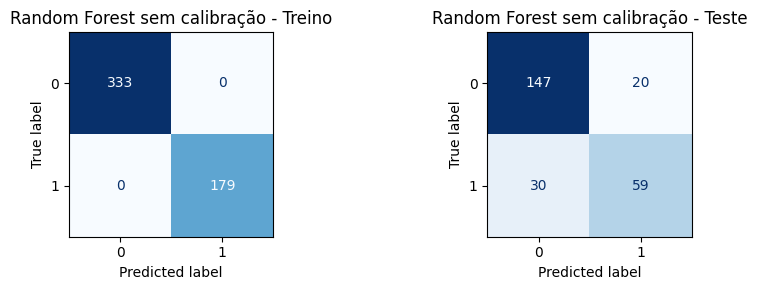

In [15]:
rf = RandomForestClassifier(random_state=42).fit(X_train, y_train)

# Previsões no conjunto de treino
y_train_pred_cal = rf.predict(X_train)
# print("\nDesempenho no conjunto de Treino")
# print(classification_report(y_train, y_train_pred_cal))
cm_train_cal = confusion_matrix(y_train, y_train_pred_cal)

# Previsões no conjunto de teste
y_test_pred_cal = rf.predict(X_test)
# print("\nDesempenho no conjunto de Teste")
# print(classification_report(y_test, y_test_pred_cal))
cm_test_cal = confusion_matrix(y_test, y_test_pred_cal)

print('Score dos dados de treino:', rf.score(X_train, y_train))
print('Score dos dados de teste:', rf.score(X_test, y_test))

plot_confusion_matrices(cm_train_cal, cm_test_cal, 'Random Forest sem calibração')

Encontrar os melhores hiper parametros para um respetivo modelo é um processo demorado.
No caso do RandomForestClassifier, todos os hiper parâmetros têm um papel fundamental (uns mais do que outros) para melhorar a prestação do classificador, no entanto, por motivos de processamento e de tempo não é possível testá-los a todos. Sendo assim, vamos realçar os hiper parametros mais importantes e vão ser esses a ser utilizados durante o processo de GridSearch. São eles:

⦁	n_estimators: Número de árvores de decisão na floresta, ou seja, em todo o classificador. Normalmente, a precisão converge para um limite à medida que o valor aumenta, o que ajuda a reduzir a redundância.
⦁	max_depth: Profundidade máxima permitida para cada árvore. Se tiver um valor demasiado alto pode acabar por provocar overffiting, se tiver um valor muito baixo, o inverso. De um modo geral, é bastante eficiente a controlar a complexidade do modelo;
⦁	min_samples_leaf: O número mínimo de amostras que deve existe num só nó para que seja considerado um "nó folha". Este parâmetro força os nós folha a representarem um número mínimo de observações, resultando em previsões mais robustas e menos sensíveis a ruido. Bastante útil para reduzir o overfitting;
⦁	min_samples_split: O número mínimo de amostras num nó para que este possa ser dividido. Ou seja, impeder que o processo de divisão comece se o nó for demasiado pequeno, garantindo que as divisões se baseiam em amostras representativas;
⦁	max Features: O número de geatures selecionadas aleatoriamente para considerar a melhor divisão em cada nó. Esta característica diferencia este modelo de outros uma vez que limita as suas features, forçando as árvores a explorar diferentes subconjuntos (esta baixa correlação é crucial para o poder de ensemble).
⦁	bootstrap: Indica se a amostragem das observações para o treino de cada árvore é feita com reposição, ou seja, se o seu valor for igual a True, cada árvore é treinada num conjunto aleatório de dados de treino. Caso seja False, todas as árvores são treinadas em todo o conjunto de dados, aumentando a correlação entre elas e muitas vezes o overfitting.
⦁	class_weight: Define a ponderação de cada classe. Se o conjunto de dados for desbalanceado, ou seja, se houver uma classe em minoritária, este parâmetro consegue balancear o conjunto.


Estes são os hiper parâmetros que terão mais impacto na aprendizagem neste modelo, no entanto falta ainda encontrar quais são os melhores valores para cada um deles. Para tal foi realizado um processo de tentativa e erro, no qual se foi ajustando aos poucos os conjuntos de valores até se achar os mais indicados. 
Resumidamente, começamos por testar apenas um dos parametros (Teste 1) com uma gama de valores variada e obtemos assim o valor mais indicado para o respetivo hiper parâmetro. Ao avançarmos (Teste 2) adicionamos um novo hiper parâmetro e reduzimos o intervalo de valores do parâmetro anterior, com base nos resultados obtidos. Repetimos este processo para todos os hiper parametros até estarmos satisfeitos com os resultados obtidos. Como é possível observar na célula abaixo, foram realizados ao todo 7 testes, correspondentes aos 7 parametros que queremos encontrar, e após analisar cuidadosamente os resultados do best_params_ para todos os testes, chegou-se à conclusão de quais os melhores valores, ou intervalos de valores para cada hiper parâmetro. 
Por motivos de processamento, não é possível testar todas as combinações possíveis, uma vez que existem "infinitas" combinações para este modelo, no entanto, tentou-se escolher, para a grid final, conjuntos com os mesmos intervalos entre valores e com uma margem significativa para o parâmetro mais adequado (exemplo.: para o hiper parâmetro min_samples_split, em quase todos os testes, o valor mais adequado é o 4, assim sendo, adicionou-se uma margem de 2 valores, em aabmos os sentidos e com os mesmos intervalões entre si). Nota: Estas margens surgem também como uma flexibilidade do modelo e da grid, visto que, com pré-processamento, os hiper parametros possam vir divergir dos originais. 

Os melhores parametros podem ser visualizados abaixo.

In [16]:
# Teste 1
param_grid = {
    'n_estimators': [100, 200, 300, 500, 800, 1200, 1500],
}
# Melhores parâmetros: {'n_estimators': 1200} - Teste 1

# Teste 2
param_grid = {
    'n_estimators': [100, 200, 300, 500, 800, 1200],
    'max_depth': [None, 5, 10, 15, 20, 30, 40, 60, 80],
}
# Melhores parâmetros: {'max_depth': 15, 'n_estimators': 800} - Teste 2

# # Teste 3
param_grid = {
    'n_estimators': [100, 200, 300, 500, 800],
    'max_depth': [5, 10, 15, 20, 30],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6, 8, 10, 15, 20],
}
# # Melhores parâmetros: {'max_depth': 10, 'min_samples_leaf': 4, 'n_estimators': 300} -Teste 3

# Teste 4
param_grid = {
    'n_estimators': [100, 200, 300, 500, 800],
    'max_depth': [5, 10, 15, 20, 30],
    'min_samples_leaf': [4, 5, 6, 8, 10],
    'min_samples_split': [2, 3, 4, 5, 8, 10, 12, 15, 20],
}
# Melhores parâmetros: {'max_depth': 10, 'min_samples_leaf': 4, 'n_estimators': 300 'min_samples_split': 2} - Teste 4

# Teste 5
param_grid = {
    'n_estimators': [200, 300, 500, 800],
    'max_depth': [5, 10, 15, 20],
    'min_samples_leaf': [4, 5, 6, 8, 10],
    'min_samples_split': [2, 3, 4, 5, 8],
    'max_features': ['sqrt', 'log2', None, 0.2, 0.3, 0.4, 0.5, 0.7],
}
# Melhores parâmetros: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300} - Teste 5

# Teste 6
param_grid = {
    'n_estimators': [200, 300, 500, 800],
    'max_depth': [5, 10, 15, 20],
    'min_samples_leaf': [4, 5, 6, 8, 10],
    'min_samples_split': [2, 3, 4, 5, 8],
    'max_features': ['sqrt', 'log2', None, 0.2, 0.3],
    'bootstrap': [True, False],
}
# Melhores parâmetros: {'bootstrap': False, 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 500}

# Teste 7 
param_grid = {
    'n_estimators': [200, 300, 500, 800],
    'max_depth': [5, 10, 15, 20],
    'min_samples_leaf': [4, 5, 6, 8, 10],
    'min_samples_split': [2, 3, 4, 5, 8],
    'max_features': ['sqrt', 'log2', None, 0.2, 0.3],
    'bootstrap': [True, False],
    'class_weight': [None, 'balanced', 'balanced_subsample'],
}

In [17]:

def calibrate_rndForest(param_grid_RndForest, X_dataset,y_dataset, cv):
    grid_search_RndF = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42), 
        param_grid=param_grid_RndForest,
        cv=cv,
        n_jobs=-1, #-1 é para usar todos os cores em processamento paralelo
    )

    # Treinar o modelo com GridSearchCV
    grid_search_RndF.fit(X_dataset, y_dataset)  
    print(grid_search_RndF.best_params_)

    # Usar o melhor modelo encontrado
    return grid_search_RndF.best_estimator_, grid_search_RndF.best_params_

# param_grid_RndForest = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [None, 10, 20],
# }
# param_grid_RndForest = {
#     'n_estimators': [100, 200, 300, 500, 800, 1200, 1500],
#     'max_depth': [None, 5, 10, 15, 20, 30, 40, 60, 80],
# }

# # Grid Final
# param_grid_RndForest = {
#     'n_estimators': [200, 300, 500, 800],
#     'max_depth': [5, 10, 15, 20],
#     'min_samples_leaf': [4, 5, 6, 8, 10],
#     'min_samples_split': [2, 3, 4, 5, 8],
#     'max_features': ['sqrt', 'log2', None, 0.2, 0.3],
#     'bootstrap': [True, False],
#     'class_weight': [None],
# }

param_grid_RndForest = {
    'n_estimators': [200, 300, 400, 500, 600],
    'max_depth': [10, 15, 17, 20],
    'min_samples_leaf': [2, 3, 4, 5, 6],
    'min_samples_split': [1, 2, 3, 4, 5],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False],
    'class_weight': [None],
}

rndforest_calibrated, rndforest_best_params = calibrate_rndForest(param_grid_RndForest,X_train,y_train, cv)

C:\Users\alice\AppData\Roaming\Python\Python313\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
3000 fits failed out of a total of 15000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3000 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\alice\AppData\Roaming\Python\Python313\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\alice\AppData\Roaming\Python\Python313\site-packages\sklearn\base.py", line 1358, in wrapper
    estimator._validate_params()
    ~~~~~~~~~~~~~~~~~~~~~~~~~~^^
  File "C:\Users\alice\AppData\Roaming\

{'bootstrap': True, 'class_weight': None, 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 6, 'min_samples_split': 2, 'n_estimators': 200}


Com os hiper parametros encontrados vamos seguir para a previsão dos dados com base no classificador treinado anteriormente. Para conseguirmos compreender se houve algum tipo de melhoria após a calibração, vamos comparar as matrizes antes e após a mesma.
Assim sendo, houve uma melhoria significativa após a calibração do modelo, uma vez que conseguimos generalizá-lo para o dataset que estamos a usar e diminuir o overfitting que existia antes da calibração. Podemos observar isso quando verificamos a variação dos scores antes e depois. Previamente existia quase 20% (1.0 e 0.79) de diferença ao invés dos 11% (0.91 e 0.79) o que indica uma estabilidade do modelo, onde deixou de apenas memorizar o ruído e começou a aceitar erros de classificação. Para além disso, houve uma subtil ligeira (0.03 casas decimais) entre os resultados dos testes.
Ainda relacionado com a comparação entre o antes e o depois da calibração, é de notar uma melhoria na forma como o modelo lida com a Classe 1 (no conjunto de teste), apesar do ligeiro aumento em termos de Accuracy (score). Antes, o precision e o recall eram, respetivamente, 0.72 e 0.65 e após calibração 0.76 e 0.61, indicando que o modelo previu e classificou um aumento de '1' que pertenciam a essa mesma classe mas falha a identificar um número ligeiramente maior de casos da Clasee 1.

Fazendo agora uma comparação entre o conjunto de treino e teste, com calibração, num modo geral, conseguimos identificar que o gap entre os scores diminui, o que prova a tentativa de generalização efetuada com a procura dos hiper parametros. Para além disso, o conjunto de teste apresenta um numero maior de FN (falsos negativos) mas com o mesmo numero de FP (falsos positivos).

De um modo geral, a calibração foi bem sucedida para o nosso objetivo principal, reduzir o overfitting e melhorar a estabilidade do modelo. No entanto, as matrizes de confusão sugerem que a identificação da Classe 1 continua a ser o maior desafio, com o aumento dos FN que é o nosso principal obejtivo quando estudamos datasets ligados à área da saude. As possíveis soluções para este problema podem ser:
⦁	Ajustar o hiper parametro do class_weight para 'balanced', tornando o modelo mais sensível e ajustar um pouco a quantidade de valores em cada classe;
⦁	Otimizar o threshold (limiar), ou seja, sem recalibrar os hiper parametros, podemos tentar reduzir o limiar de decisão para um valor mais baixo (ao invés do defualt 0.5), para tornar o modelo mais adequado a prever a Classe 1.

Obptámos por seguir a segunda solução


Desempenho no conjunto de Treino
              precision    recall  f1-score   support

           0       0.89      0.94      0.92       333
           1       0.88      0.79      0.83       179

    accuracy                           0.89       512
   macro avg       0.89      0.87      0.87       512
weighted avg       0.89      0.89      0.89       512


Desempenho no conjunto de Teste
              precision    recall  f1-score   support

           0       0.82      0.84      0.83       167
           1       0.69      0.66      0.68        89

    accuracy                           0.78       256
   macro avg       0.76      0.75      0.76       256
weighted avg       0.78      0.78      0.78       256

Score dos dados de treino: 0.888671875
Score dos dados de teste: 0.78125


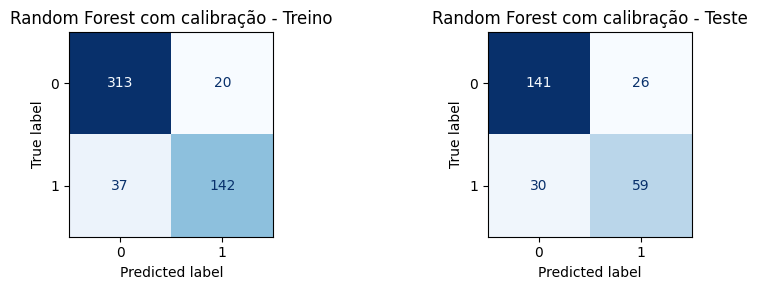

In [18]:
# Previsões no conjunto de treino
def predict_rndForest(rndforest_model, X_train,y_train,X_test,y_test ):

    # Previsões no conjunto de treino
    y_train_pred_cal = rndforest_model.predict(X_train)
    print("\nDesempenho no conjunto de Treino")
    print(classification_report(y_train, y_train_pred_cal))
    cm_train_cal = confusion_matrix(y_train, y_train_pred_cal)

    # Previsões no conjunto de teste
    y_test_pred_cal = rndforest_model.predict(X_test)
    print("\nDesempenho no conjunto de Teste")
    print(classification_report(y_test, y_test_pred_cal))
    cm_test_cal = confusion_matrix(y_test, y_test_pred_cal)

    print('Score dos dados de treino:', rndforest_model.score(X_train, y_train))
    print('Score dos dados de teste:', rndforest_model.score(X_test, y_test))

    # Plotar matrizes de confusão usando a função
    plot_confusion_matrices(cm_train_cal, cm_test_cal, 'Random Forest com calibração')

    return cm_test_cal
    
    
cm_teste_calibracao = predict_rndForest(rndforest_calibrated, X_train,y_train,X_test,y_test)

Vamos seguir, portanto, para a procura do melhor limiar de classificação. Este processo é bastante importante quando queremos determinar o valor de "corte" ideal para as probabilidades de previsão de um modelo de classificação. De um modo geral, serve para reequilibrar or erros do modelo (Falsos Positivos e Falsos Negativos), maximizando uma métrica específica, sendo possível assim ajustar a sensibilidade do modelo. No nosso caso, vamos usar a função find_threshold para otimizar o F1-score (precision e recall) em vez da Accuracy (Precisão), o que é fundamental em problemas de classificação binária desequilibrada ou Falsos Negativos.



Limiar (validação cruzada): 0.36734693877551017
F1-Score com limiar: 0.6735218508997429
F1-Scores: [0.5180897250361794, 0.5377643504531722, 0.5508607198748043, 0.5616883116883117, 0.576271186440678, 0.591304347826087, 0.6131386861313869, 0.6197718631178707, 0.6340508806262231, 0.6372745490981964, 0.6380368098159509, 0.6388308977035491, 0.6466809421841542, 0.6535087719298246, 0.6636568848758465, 0.6682242990654206, 0.6650602409638554, 0.6650124069478908, 0.6735218508997429, 0.6684210526315789, 0.6539509536784741, 0.6402266288951841, 0.6491228070175439, 0.6428571428571429, 0.6441717791411042, 0.6292834890965732, 0.5987261146496815, 0.5901639344262295, 0.5733333333333334, 0.5723905723905723, 0.5524475524475524, 0.5441696113074205, 0.5362318840579711, 0.5093632958801498, 0.49230769230769234, 0.448, 0.4214876033057851, 0.3776824034334764, 0.336283185840708, 0.2922374429223744, 0.21904761904761905, 0.15920398009950248, 0.13131313131313133, 0.08421052631578947, 0.043478260869565216, 0.0329670

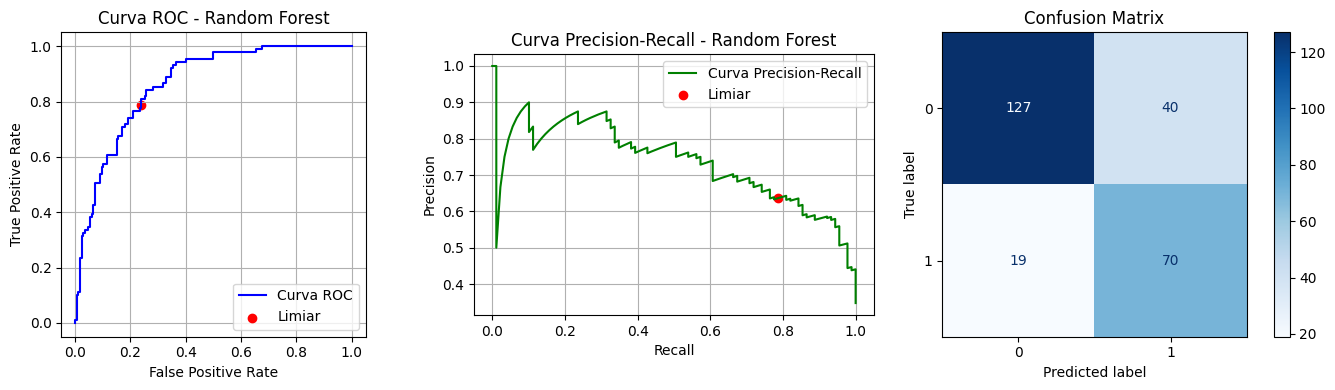

In [19]:
# Encontrar o limiar ótimo usando validação cruzada
def rndForest_with_threshold(X_train, y_train,X_test,y_test, cv,rndforest_best_params, rndforest_calibrated):
    best_threshold_f1, best_cv_f1, f1_scores = find_threshold(
        RandomForestClassifier(random_state=42),
        X_train,
        y_train,
        cv,
        param_grid=rndforest_best_params
    )

    print(f"Limiar (validação cruzada): {best_threshold_f1}")
    print(f"F1-Score com limiar: {best_cv_f1}")
    print(f"F1-Scores: {f1_scores}")

    # Obter probabilidades no conjunto de teste e aplicar novo limiar apenas á classe positiva
    y_test_proba = rndforest_calibrated.predict_proba(X_test)
    y_test_proba = y_test_proba[:,1] # Obtem as probabiliades da classe positiva
    y_test_pred_threshold = (y_test_proba >= best_threshold_f1).astype(int)
  
    # Calcular curvas para visualização
    # fp -> false positive
    # tp -> true positive
    fp, tp, thresholds_roc = roc_curve(y_test, y_test_proba)
    roc_auc = auc(fp, tp)
    print("ROC AUC Score:", roc_auc)
    
    report_dict = classification_report(y_test, y_test_pred_threshold, output_dict=True)
    print(classification_report(y_test, y_test_pred_threshold))

    precision_vals, recall_vals, thresholds_pr = precision_recall_curve(y_test, y_test_proba)

    # thresholds_pr - best_threshold_f1 calcula a distancia entre 2 arrays
    # retorna a distancia absoluta, e nós queremos o valor minimo, que seria o limiar mais próximo, com base no f1-score
    # np.argmin retorna o index do array correspondente a valor do array que tem a menor distancia
    idx_closest = np.argmin(np.abs(thresholds_pr - best_threshold_f1))

    cm_test = confusion_matrix(y_test, y_test_pred_threshold)

    # Calcular pontos para os gráficos com limiar otimizado
    fp_threshold = cm_test[0, 1] / cm_test[0, :].sum()  # FP / (TN + FP)
    tp_threshold = cm_test[1, 1] / cm_test[1, :].sum()  # TP / (TP + FN)

    plot_threshold_analysis(
        fp, tp, roc_auc,
        recall_vals, precision_vals,
        cm_test,
        (fp_threshold, tp_threshold),
        (recall_vals[idx_closest], precision_vals[idx_closest]),
        'Random Forest',
    )
    
    return cm_test, fp, tp, roc_auc, recall_vals, precision_vals, report_dict

cm_test_limiar, rf_fpr, rf_tpr, rf_roc_auc, rf_recall, rf_precision, rndforest_report = rndForest_with_threshold(X_train, y_train,X_test,y_test, cv,rndforest_best_params, rndforest_calibrated)

Primeiramente, o limiar foi alterado com 0.5 para 0.367, que ajudou a maximizar o F1-score, assim sendo, com um limiar mais baixo, o modelo precisa de menos confiança, apenas 36.7% de probabilidade para prever a Classe 1 (processo indicado para aumentar o Recall). Com base na análise da curva ROC, um score de 0.844 é bastante bom, indicando que o modelo tem um excelente poder discriminatório entres as classes. Em relação ao ponto vermelho presente na figura (limiar 0.367), está mais localizado no topo esquerdo, o que é consistente com o aumento do Recall. Em relação à curva precision-recall, o ponto está posicionado numa zona que equilibra bem a precisão e o recall (altura e comprimento, respetivamente) e a curva demonstra que, para obter um Recall de 0.81 a Precisão inevitavelmente cai para 0.62.

Para além disso, com base no desempenho do conjunto de teste

Ainda dentro deste processo, vamos agora comparar as matrizes de confusão com e sem limiar. É possível observar que todos as métricas sofreram alterações, nomeadamente a redução das identificações corretas da Classe 0, o aumento significativo de Falsos Positivos, o aumento das identificações corretas da Classe 1 e, o mais importante, a redução significante em falhar a identificação da Classe 1. Resumindo, a otimização do limiar foi crucial para o sucesso do tratamento da Classe 1 (classe mais difícil de prever, como detectamos anteriormente), isto resulta num Recall muito mais alto para a Classe 1, no entanto, para obter estes resultados, o modelo teve ficar mais "agressivo", no sentido em que as previsões da Classe 1 resultaram no aumento dos casos de Falsos Positivos, que aumentaram significamente de 17 para 45, o que resulta numa Precision mais baixa para esta mesma classe e para o modelo no geral.
 
Assim sendo, após encontrar o limiar, o modelo final é o que melhor satisfaz a métrica do F1-score, uma vez que a grande redução dos Falsos Negativos supera o custo de aumento nos Falsos Positivos.

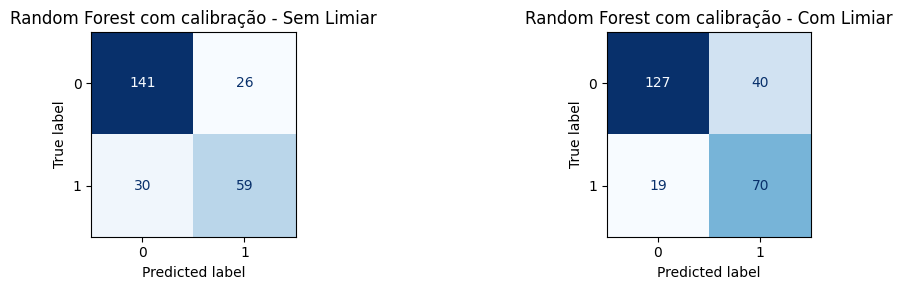

In [20]:
plot_CF(cm_teste_calibracao, cm_test_limiar, 'Random Forest com calibração - Sem Limiar', 'Random Forest com calibração - Com Limiar')

Concluindo, com base em toda a análise e nos resultados destas três fases (sem calibração, com calibração e com limiar), podemos tirar algumas conclusões sobre o modelo. O processo de otimização transformou o modelo, que estava num estado de overfitting a um estado de generalização controlada, onde foi ajustado para maximizar as diferenças entre a precisão e o recall.

Meter aqui as árvores de decisão


Melhor árvore no índice 17 com uma acurracy de 0.7930


Text(0.5, 1.0, 'Melhor Árvore de decisão(no índice 17)')

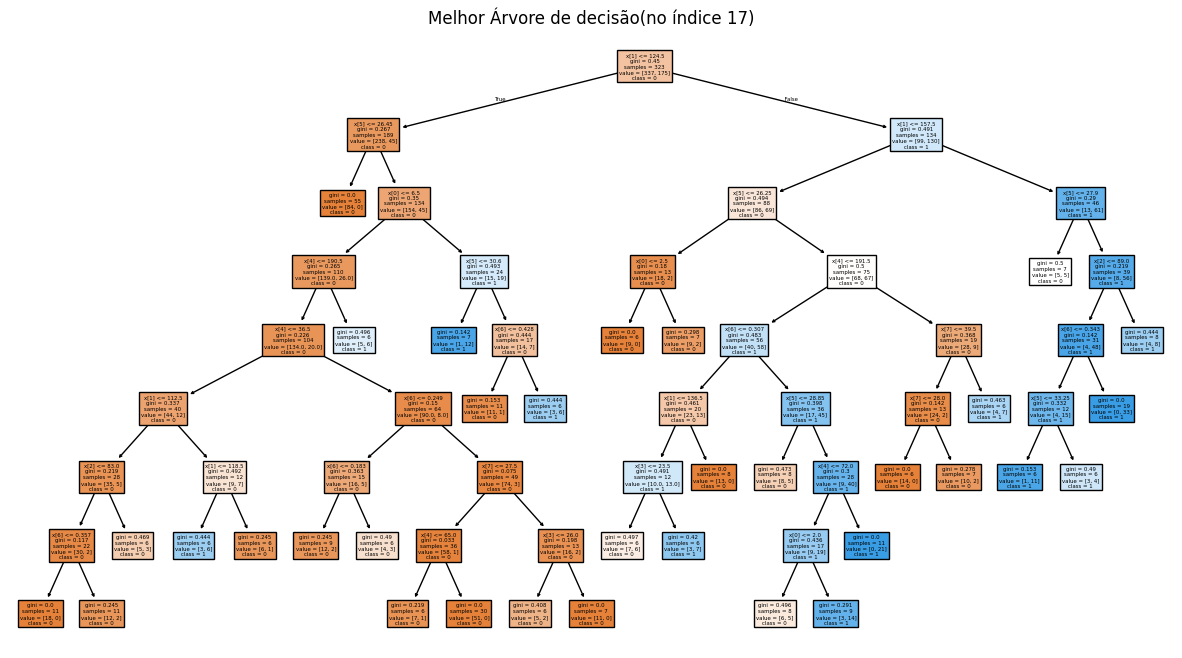

In [21]:
# Encontrar a melhor árvore de decisão paras os dados de teste

from sklearn.metrics import accuracy_score
from sklearn.tree import plot_tree

# Avaliar cada árvore individualmente
scores = []
for i, tree in enumerate(rndforest_calibrated.estimators_):
    y_pred = tree.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    scores.append(acc)

# Encontrar o índice da melhor árvore
best_idx = np.argmax(scores)
best_tree = rndforest_calibrated.estimators_[best_idx]
print(f"Melhor árvore no índice {best_idx} com uma acurracy de {scores[best_idx]:.4f}")

# Visualizar a melhor árvore
plt.figure(figsize=(15, 8))
plot_tree(
    best_tree,
    filled=True,
    feature_names=X.columns if hasattr(X, "columns") else None,
    class_names=[str(c) for c in np.unique(y)],
    max_depth=None     # coloque None se quiser visualizar a árvore completa
)
plt.title(f"Melhor Árvore de decisão(no índice {best_idx})")

### 3.2.3 - Logistic Regression

O Logistic Regression é um algoritmo de classificação linear muito utilizado. Este algoritmo prevê a probabilidade de um determinado ponto de dados pertencer a uma dada classe, utilizando a função logística.

Em primeiro lugar, é calculada uma pontuação linear, que é a soma ponderada das features de entrada e dos seus respetivos coeficientes. Dado que esta pontuação linear pode variar entre -$\infty$ e $\infty$ e é pretendido obter uma função de probabilidade que varie entre 0 e 1, é aplicada uma função logística à pontuação. Se o valor da pontuação for muito grande e positivo, aproxima-se de 1. Se for muito grande e negativo, aproxima-se de 0 e se for 0, é 0.5.

Após ser calculada a probabilidade, o modelo toma a decisão com base num threshold. Se a probabilidade estiver acima do threshold, a observação é classificada como sendo da classe 1, caso contŕário, é classificada na classe 0.

Para entendermos os hiperparâmetros utilizados neste modelo, temos que conhecer o conceito essencial de "regularização". A regularização é uma técnica para prevenir o sobreajuste do modelo, que acontece quando este se tenta ajustar demasiado aos dados de treino, perdendo a capacidade de generalizar para novos dados. 

Os hiperparâmetros "penalty" e "C" são utilizados para obter esta regularização na seguinte medida:

- O parâmetro "penalty" define o tipo de restrição aplicada aos coeficientes do modelo, enquanto "C" controla a intensidade dessa restrição.
- O tipo de restrição pode ser de "l2" (Ridge), "l1" (Lasso) ou "elasticnet". "l2" adiciona a soma dos quadrados dos coeficientes de peso ao custo, de modo a reduzir os coeficientes em direção a 0 de forma uniforme, mas sem os tornar 0, mantendo assim todas as features no modelo. "l1" adiciona a soma dos módulos dos coeficientes ao custo, tendo a capacidade de forçar coeficientes de features a 0, removendo-os do modelo. "elasticnet" é uma combinação linear de "l1" e "l2". "l2" é mais utilizado (e melhor) para lidar com dados cuja correlação entre features seja muito alta, enquanto que "l1" é melhor para selecionar determinadas features em datasets com muitas variáveis, simplificando o modelo. "elasticnet" tenta uma combinação dos dois.
- O parâmetro "C" é equivalente ao inverso da força de regularização. Quanto maior este valor faz com que o modelo se tente ajustar mais aos dados de treino, enquanto que quanto mais próximo de 0, mais o modelo se torna resistente ao ruído, mas podendo levar ao underfitting.

O híperparâmetro "solver" é o algoritmo que o LogisticRegression utiliza para encontrar os valores ótimos dos coeficientes que minimizam a função de custo. A escolha de um solver depende do tipo de penalidade que suporta e do tamanho do dataset. Por exemplo, o solver "lbfgs" (padrão) é mais adequado para datasets menores, suportando apenas o tipo de restrição "l2" enquanto, para datasets maiores, o solver "saga" é mais adequado, suportando todos os tipos de penalidade.

Fitting 5 folds for each of 310 candidates, totalling 1550 fits
Best parameters: {'C': np.float64(0.004641588833612777), 'max_iter': 200, 'penalty': 'l2', 'solver': 'lbfgs'}

Desempenho no conjunto de Treino
              precision    recall  f1-score   support

           0       0.78      0.88      0.83       333
           1       0.72      0.55      0.62       179

    accuracy                           0.77       512
   macro avg       0.75      0.72      0.73       512
weighted avg       0.76      0.77      0.76       512


Desempenho no conjunto de Teste
              precision    recall  f1-score   support

           0       0.83      0.87      0.85       167
           1       0.73      0.66      0.69        89

    accuracy                           0.80       256
   macro avg       0.78      0.77      0.77       256
weighted avg       0.79      0.80      0.79       256

Score dos dados de treino: 0.765625
Score dos dados de teste: 0.796875


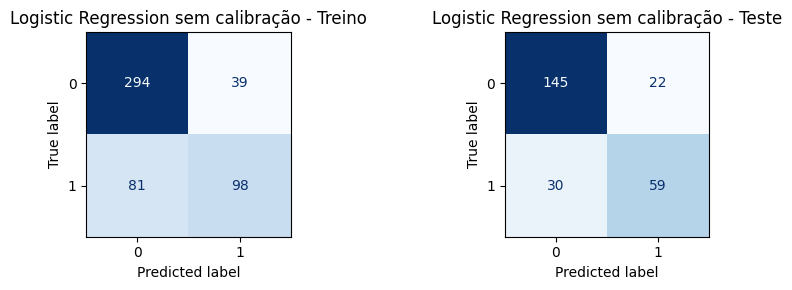


Desempenho no conjunto de Treino
              precision    recall  f1-score   support

           0       0.78      0.88      0.83       333
           1       0.71      0.54      0.61       179

    accuracy                           0.76       512
   macro avg       0.74      0.71      0.72       512
weighted avg       0.76      0.76      0.75       512


Desempenho no conjunto de Teste
              precision    recall  f1-score   support

           0       0.83      0.87      0.85       167
           1       0.73      0.66      0.69        89

    accuracy                           0.80       256
   macro avg       0.78      0.77      0.77       256
weighted avg       0.79      0.80      0.79       256

Score dos dados de treino: 0.76171875
Score dos dados de teste: 0.796875


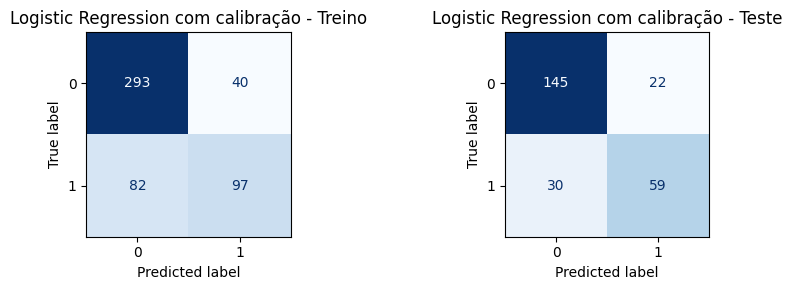

In [22]:
logistic = LogisticRegression(random_state=42, max_iter=1000).fit(X_train, y_train)

def calibrate_logistic(param_grid_logistic, X_dataset,y_dataset, cv):
    grid_search_logistic = GridSearchCV(
    estimator=LogisticRegression(random_state=42), 
        param_grid=param_grid_logistic,
        cv=cv,
        n_jobs=-1,
        verbose=1
    )

    grid_search_logistic.fit(X_dataset, y_dataset)

    print("Best parameters:", grid_search_logistic.best_params_)
    return grid_search_logistic.best_estimator_, grid_search_logistic.best_params_


param_grid_logistic = [
    {
        'solver': ['lbfgs', 'newton-cg'],
        'penalty': ['l2'],
        'C': np.logspace(-3, 3, 10),
        'max_iter': [200, 500, 2000, 5000]
    },
    {
        'solver': ['liblinear'],
        'penalty': ['l1', 'l2'],
        'C': np.logspace(-3, 3, 10),
        'max_iter': [200, 500, 2000, 5000]
    },
    {
        'solver': ['saga'],
        'penalty': ['l1', 'l2'],
        'C': np.logspace(-3, 3, 10),
        'max_iter': [5000, 10000, 20000] 
    },
    {
        'solver': ['saga'],
        'penalty': ['elasticnet'],
        'l1_ratio': [0, 0.5, 1.0],  # needed for elasticnet
        'C': np.logspace(-3, 3, 10),
        'max_iter': [5000, 10000, 20000] 
    }
]



logistic_calibrated, logistic_best_params = calibrate_logistic(param_grid_logistic,X_train,y_train, cv)

def predict_logistic(logistic_model, X_train,y_train,X_test,y_test, calibrated=False ):
    
    # Previsões no conjunto de treino
    y_train_pred_cal = logistic_model.predict(X_train)
    print("\nDesempenho no conjunto de Treino")
    print(classification_report(y_train, y_train_pred_cal))
    cm_train_cal = confusion_matrix(y_train, y_train_pred_cal)

    # Previsões no conjunto de teste
    y_test_pred_cal = logistic_model.predict(X_test)
    print("\nDesempenho no conjunto de Teste")
    print(classification_report(y_test, y_test_pred_cal))
    cm_test_cal = confusion_matrix(y_test, y_test_pred_cal)

    print('Score dos dados de treino:', logistic_model.score(X_train, y_train))
    print('Score dos dados de teste:', logistic_model.score(X_test, y_test))

    # Plotar matrizes de confusão usando a função
    if(not calibrated):
        plot_confusion_matrices(cm_train_cal, cm_test_cal, 'Logistic Regression sem calibração')
        return
    plot_confusion_matrices(cm_train_cal, cm_test_cal, 'Logistic Regression com calibração')

    return cm_test_cal

cm_test_logistic_no_calib = predict_logistic(logistic, X_train,y_train,X_test,y_test)
cm_teste_logistic = predict_logistic(logistic_calibrated, X_train,y_train,X_test,y_test, True)


Limiar (validação cruzada): 0.24489795918367346
F1-Score com limiar: 0.6566523605150214
F1-Scores: [0.5180897250361794, 0.5219941348973607, 0.5305514157973175, 0.5426829268292683, 0.5641838351822503, 0.5843071786310517, 0.6031195840554593, 0.6220614828209765, 0.6256983240223464, 0.629126213592233, 0.6374501992031872, 0.640495867768595, 0.6566523605150214, 0.6547884187082406, 0.6558139534883721, 0.6407766990291263, 0.6433915211970075, 0.6321243523316062, 0.6166219839142091, 0.6243093922651933, 0.6210826210826211, 0.6355685131195336, 0.6309523809523809, 0.6116207951070336, 0.6105919003115264, 0.6050955414012739, 0.5798045602605864, 0.5780730897009967, 0.5782312925170068, 0.5644599303135889, 0.574468085106383, 0.5714285714285714, 0.5407407407407407, 0.5057471264367817, 0.4921875, 0.4596774193548387, 0.4214876033057851, 0.4117647058823529, 0.3739130434782609, 0.3090909090909091, 0.29357798165137616, 0.2535211267605634, 0.20388349514563106, 0.1414141414141414, 0.09375, 0.06451612903225806, 

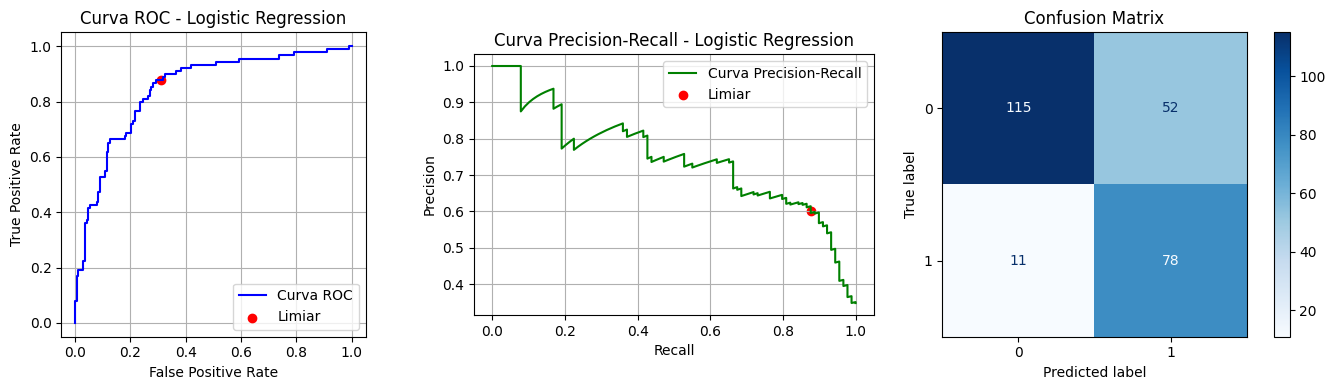

In [23]:

# Encontrar o limiar ótimo usando validação cruzada
def logistic_with_threshold(X_train, y_train,X_test,y_test, cv,logistic_best_params, logistic_calibrated):
    best_threshold_f1, best_cv_f1, f1_scores = find_threshold(
        LogisticRegression(random_state=42, max_iter=1000),
        X_train,
        y_train,
        cv,
        param_grid=logistic_best_params
    )

    print(f"Limiar (validação cruzada): {best_threshold_f1}")
    print(f"F1-Score com limiar: {best_cv_f1}")
    print(f"F1-Scores: {f1_scores}")

    y_test_proba = logistic_calibrated.predict_proba(X_test)
    y_test_proba = y_test_proba[:,1] 
    y_test_pred_threshold = (y_test_proba >= best_threshold_f1).astype(int)

    print(f"\nDesempenho com limiar ({best_threshold_f1}):")

    # Calcular curvas para visualização
    # fp -> false positive
    # tp -> true positive
    fp, tp, thresholds_roc = roc_curve(y_test, y_test_proba)
    roc_auc = auc(fp, tp)
    print("ROC AUC Score:", roc_auc)
    
    report_dict = classification_report(y_test, y_test_pred_threshold, output_dict=True)
    print(report_dict)

    precision_vals, recall_vals, thresholds_pr = precision_recall_curve(y_test, y_test_proba)

    # thresholds_pr - best_threshold_f1 calcula a distancia entre 2 arrays
    # retorna a distancia absoluta, e nós queremos o valor minimo, que seria o limiar mais próximo, com base no f1-score
    # np.argmin retorna o index do array correspondente a valor do array que tem a menor distancia
    idx_closest = np.argmin(np.abs(thresholds_pr - best_threshold_f1))

    cm_test = confusion_matrix(y_test, y_test_pred_threshold)

    # Calcular pontos para os gráficos com limiar calculado
    fp_threshold = cm_test[0, 1] / cm_test[0, :].sum()  # FP / (TN + FP)
    tp_threshold = cm_test[1, 1] / cm_test[1, :].sum()  # TP / (TP + FN)

    plot_threshold_analysis(
        fp, tp, roc_auc,
        recall_vals, precision_vals,
        cm_test,
        (fp_threshold, tp_threshold),
        (recall_vals[idx_closest], precision_vals[idx_closest]),
        'Logistic Regression',
    )
    return cm_test, fp, tp, roc_auc, recall_vals, precision_vals, report_dict

logistic_calibrated_cm_thres, log_fpr, log_tpr, log_roc_auc, log_recall, log_precision, logistic_report = logistic_with_threshold(X_train, y_train,X_test,y_test, cv,logistic_best_params, logistic_calibrated)

### 3.2.4 - Análise dos classificadores
- Pegar nos dados dos 3 classificadores acima, e juntar num subplot de 3 figuras
    - Printar confusion matrix dos 3 (com os dados de teste)
    - Printar as curvas roc dos 3 ao mesmo tempo

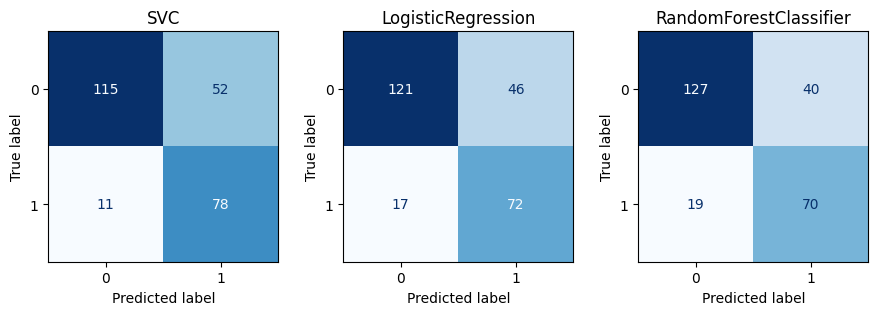

In [63]:
# Printar matrizes de confusão dos 3
# Printar Curvas Roc e Recall/ Precion dos 3

def plot_cm_3(cm_1, cm_2,cm_3, title_prefix1, title_prefix2, title_prefix3):
    size = 3
    fig, axes = plt.subplots(1, 3, figsize=(size*3, size ))
    
    # Mostra matriz de confusão 1, com o titlo desejado, title_prefix1
    disp_train = ConfusionMatrixDisplay(cm_1)
    disp_train.plot(ax=axes[0], cmap="Blues", colorbar=False)
    axes[0].set_title(f'{title_prefix1}')
    
    # Mostra matriz de confusão 2, com o titlo desejado, title_prefix2
    disp_test = ConfusionMatrixDisplay(cm_2)
    disp_test.plot(ax=axes[1], cmap="Blues", colorbar=False)
    axes[1].set_title(f'{title_prefix2}')
    
    
    disp_test = ConfusionMatrixDisplay(cm_3)
    disp_test.plot(ax=axes[2], cmap="Blues", colorbar=False)
    axes[2].set_title(f'{title_prefix3}')
    
    plt.tight_layout()
    plt.show()
    
def compare_classifiers(svc_fpr, svc_tpr, svc_roc_auc,rf_fpr, rf_tpr, rf_roc_auc, log_fpr, log_tpr, log_roc_auc):
    svc_roc_auc_round = np.round(svc_roc_auc,2)
    rf_roc_auc_round = np.round(rf_roc_auc,2)
    log_roc_auc_round = np.round(log_roc_auc,2)
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    
    # Curva ROC
    axes[0].plot(svc_fpr, svc_tpr, label=f'SVC (AUC: {svc_roc_auc_round})')
    axes[0].plot(rf_fpr, rf_tpr, label=f'Random Forest (AUC: {rf_roc_auc_round})')
    axes[0].plot(log_fpr, log_tpr, label=f'Logistic Regression (AUC: {log_roc_auc_round})')
    axes[0].set_xlabel('False Positive Rate')
    axes[0].set_ylabel('True Positive Rate')
    axes[0].set_title('Curvas ROC - Comparação dos 3 Classificadores')
    axes[0].legend()

    axes[0].grid(True)
    axes[0].axis("scaled")

    # Curva Precision-Recall
    axes[1].plot(svc_recall, svc_precision, label='SVC')
    axes[1].plot(rf_recall, rf_precision, label='Random Forest')
    axes[1].plot(log_recall, log_precision, label='Logistic Regression')
    axes[1].set_xlabel('Recall')
    axes[1].set_ylabel('Precision')
    axes[1].set_title('Curvas Precision-Recall - Comparação dos 3 Classificadores')
    axes[1].legend()
    axes[1].grid(True)
    axes[1].axis("scaled")


    plt.tight_layout()
    plt.show()

plot_cm_3(logistic_calibrated_cm_thres, svc_calibrated_cm_thres, cm_test_limiar,'SVC', 'LogisticRegression','RandomForestClassifier')

Quando olhamos para as matrizes de confusão, conseguimos observar o impacto que normalização tem no desempenho dos classificadores. Sem normalização, os três modelos têm  dificuldade geral em detectar a classe positiva, o que leva a uma quantidade de falsos negativos. Este comportamento pode ser devido à escala dos dados, com variaveis a terem mais impacto no desempenho do que outros.

Isto indica que, sem normalização, os classificadores dão mais peso às caracteristicas com maior magnitude. Como consequência, as regiões de decisão tem dificuldade em "distinguir" as classes. Ainda assim, conseguimos perceber que em termos de classificação, o mais equilibrado é o LogisticRegression, que consegue ter um desempenho mais equilibrado. O SVC está a favorcer mais a classe positiva (mais falsos positivos) e o RandomForestClassifier está a tender mais para a classe dos negativos (mais falsos negativos)

Em suma, esta fase inicial sem normalização serve como ponto de referência para compreender que o desempenho dos modelos.

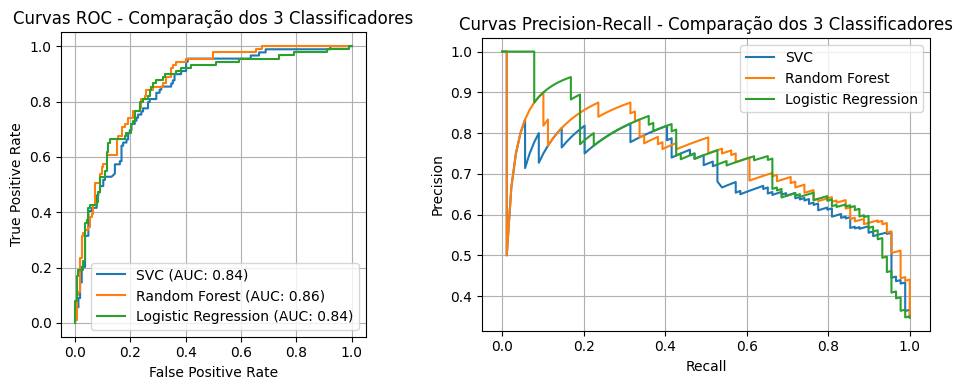

In [64]:
# Curvas ROC comparativas
compare_classifiers(svc_fpr, svc_tpr, svc_roc_auc,rf_fpr, rf_tpr, rf_roc_auc, log_fpr, log_tpr, log_roc_auc)

As curvas ROC dos três classificadores mostram semelhantes, com áreas sob a curva (AUC) próximas entre si. O Random Forest fica ligeiramente acima dos restantes, indicando uma melhor capacidade de decidir entre calasses. No entanto, os 3 classificadores apresentam um desempenho semelhante.

As curvas Precision–Recall demonstram que, sem normalização, a precisão diminui à medida que recall aumenta. Isto significa que, sempre que o classificador tenta identificar mais verdadeiros positivos, faz aumentar o número maior de falsos positivos, como também se pode reparar nas matrizes de confusão acima.

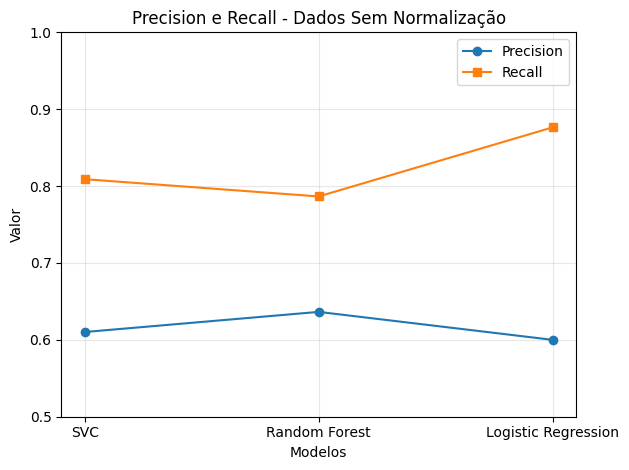

In [39]:
# Extrair Precision e Recall dos classification reports retornados pelas funções

# Sem normalização
svc_precision_no_norm = svc_report['1']['precision']
svc_recall_no_norm = svc_report['1']['recall']

rf_precision_no_norm = rndforest_report['1']['precision']
rf_recall_no_norm = rndforest_report['1']['recall']

log_precision_no_norm = logistic_report['1']['precision']
log_recall_no_norm = logistic_report['1']['recall']

models = ['SVC', 'Random Forest', 'Logistic Regression']
precision_no_norm = [svc_precision_no_norm, rf_precision_no_norm, log_precision_no_norm]
recall_no_norm = [svc_recall_no_norm, rf_recall_no_norm, log_recall_no_norm]
x = np.arange(len(models))

# Gráfico 1: Sem normalização
plt.plot(x, precision_no_norm, 'o-', label='Precision')
plt.plot(x, recall_no_norm, 's-', label='Recall')
plt.xlabel('Modelos')
plt.ylabel('Valor')
plt.title('Precision e Recall - Dados Sem Normalização')
plt.xticks(x, models)
plt.legend()
plt.ylim(0.5, 1)
plt.grid(True, alpha=0.3)


plt.tight_layout()
plt.show()


Quando analisamos os valores agregados de precision e recall, observamos que o SVC mantém uma precision mais ou menos estável, mas apresenta um recall mais baixo, o que mostra que o modelo tem alguma dificuldade em captar todos os casos positivos. No Random Forest, observamos um comportamento mais equilibrado entre as duas métricas, embora sem grande destaque em nenhuma delas, acabando por ficar num patamar intermédio em termos de desempenho global. Já na Regressão Logística, observamos normalmente o recall mais elevado entre os três modelos, conseguindo identificar uma maior proporção de positivos, mas à custa de uma precision mais fraca, o que indica que, apesar de detetar mais casos positivos, também acaba por identificar mais falsos positivos.

## 3.3 - Pré-processamento

Antes de avançar para o treino com os dados normalizados, importa perceber como os modelos reagem às _features_ tal como surgem no dataset. No caso do SVC e da Regressão Logística, são modelos que são sensiveis à escala dos dados. Como dependem de cálculos baseados em distâncias e gradientes, qualquer feature com valores muito maiores do que as restantes acaba por influenciar de forma desproporcional a fronteira de decisão, mesmo que não tenha maior relevância.

O Random Forest, por outro lado, não sofre deste problema. As árvores tomam decisões através de divisões sucessivas numa variável de cada vez, recorrendo apenas a limites. Como este processo não envolve distâncias nem operações sensíveis à magnitude das _features_, diferenças de escala não têm quase impacto nenhum no desempenho do modelo.

A normalização com StandardScaler resolve os problemas de escala ao ajustar todas as _features_ para média zero e variância um. Isto garante que os modelos sensíveis à escala aprendem padrões de forma equilibrada, evitando que certas variáveis tenham maior importancia devido a gama de valores que têm.

### 3.3.1 - Análise dos Dados Originais

Vamos começar por analisar as estatísticas dos dados originais para perceber se existe necessidade de normalização.

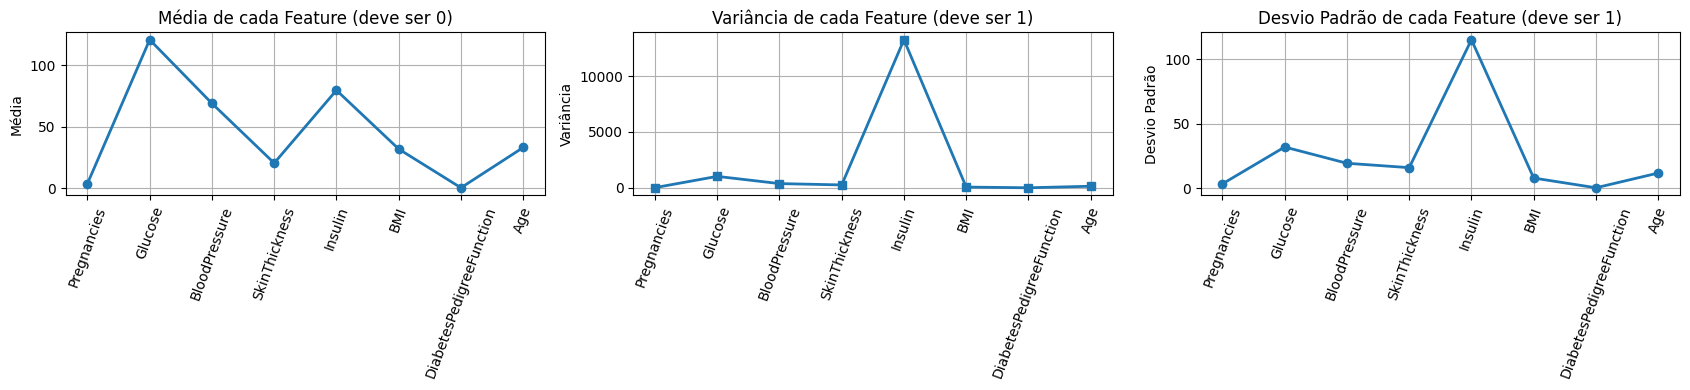

In [40]:
feature_names = [
    'Pregnancies',
    'Glucose', 
    'BloodPressure',
    'SkinThickness',
    'Insulin',
    'BMI',
    'DiabetesPedigreeFunction',
    'Age'
]

def print_stats(X_norm):
    # Calcular estatísticas dos dados normalizados (arrendondado para tirar os floats)
    means_norm = [np.round(np.mean(X_norm[:, i]),2) for i in range(len(feature_names))]
    variances_norm = [np.round(np.var(X_norm[:, i]),2) for i in range(len(feature_names))]
    stds_norm = [np.round(np.std(X_norm[:, i]),2) for i in range(len(feature_names))]
    fig, axes = plt.subplots(1, 3, figsize=(17, 4))

    # Média (deve ser ~0)
    axes[0].plot(feature_names, means_norm, marker='o', linewidth=2,)
    axes[0].set_ylabel('Média')
    axes[0].set_title('Média de cada Feature (deve ser 0)')
    axes[0].grid(True,)
    axes[0].tick_params(axis='x', rotation=70)

    # Variância (deve ser ~1)
    axes[1].plot(feature_names, variances_norm, marker='s', linewidth=2,)
    axes[1].set_ylabel('Variância')
    axes[1].set_title('Variância de cada Feature (deve ser 1)')
    axes[1].grid(True,)
    axes[1].tick_params(axis='x', rotation=70)

    # Desvio Padrão (deve ser ~1)
    axes[2].plot(feature_names, stds_norm, marker='o', linewidth=2)
    axes[2].set_ylabel('Desvio Padrão')
    axes[2].set_title('Desvio Padrão de cada Feature (deve ser 1)')
    axes[2].grid(True,)
    axes[2].tick_params(axis='x', rotation=70)

    plt.tight_layout()
    plt.show()
    
print_stats(X)

Como podemos observar nos resultados acima, as _features_ apresentam escalas muito diferentes e valores em intervalos muito grandes.
Estas diferenças e escala podem afetar de forma negativa os algoritmos _SVC_ e _Logistic Regression_, onde _features_ com valores maiores (como Insulin ou Glucose) podem ter maior impacto no modelo, enquanto _features_ com valores pequenos (como DiabetesPedigreeFunction) podem ter pouco impacto no modelo.

### 3.3.2 - Normalização com StandardScaler

Vamos agora aplicar o **StandardScaler** para transformar os dados. Esta técnica transforma cada feature de modo a que:

$$X_{normalizado} = \frac{X - \mu}{\sigma}$$

Onde:
- $\mu$ é a média da feature
- $\sigma$ é o desvio padrão da feature

Após esta transformação, todas as features terão **média 0** e **variância 1**.

In [41]:
# Normalizar os dados
scaler = StandardScaler()
X_norm = scaler.fit_transform(X)

# Dividir os dados normalizados
X_train_norm, X_test_norm, y_train_norm, y_test_norm = train_test_split(X_norm, y, test_size=1/3, stratify=y)

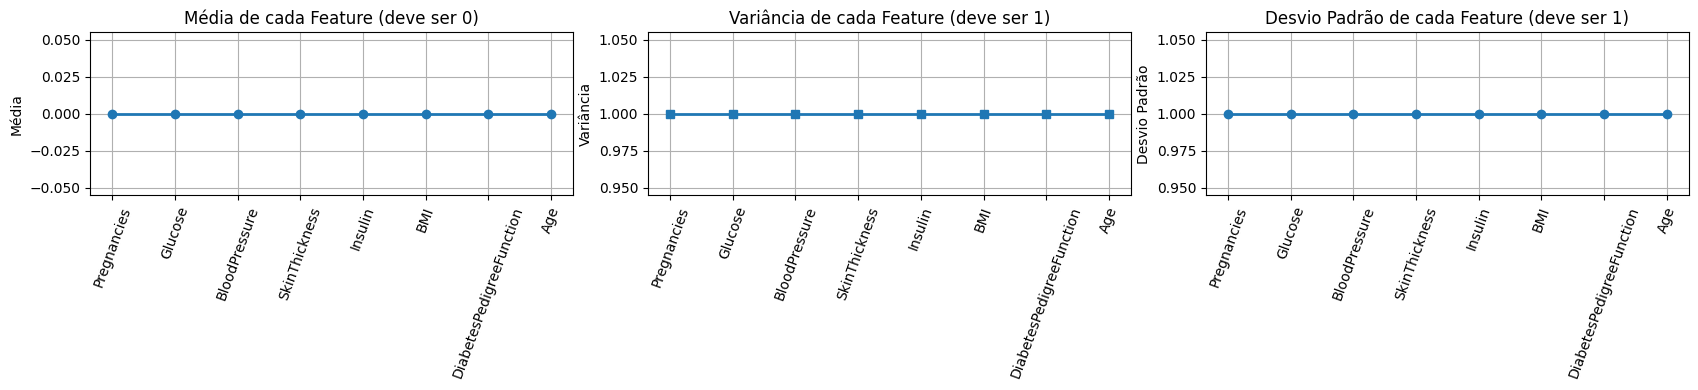

In [42]:
print_stats(X_norm)

Após aplicar a normalização, ficamos com todas as features centradas na média zero e com variância igual a um, o que coloca as variáveis todas com pesos iguais. Esta transformação é útil para modelos como o SVC e a Regressão Logística, que passam a aprender de forma mais equilibrada. Além disso, o treino consegue convergir mais rápido e o desempenho melhora, precisamente porque o modelo passa a lidar com dados com mais normalizados.

Nas secções seguintes, vamos então treinar novamente os classificadores usando estes dados normalizados e comparar diretamente com os resultados obtidos anteriormente, quando os modelos ainda estavam a trabalhar com os valores originais.

### 3.3.2 - Treino com Pré-Processamento - SVC

Aplicando o mesmo processo que no capítulo 3.2.1, temos o seguinte

In [43]:
svc_calibrated_scaled, svc_best_params_scaled = calibrate_svc(param_grid_svc, X_train_norm, y_train_norm, cv)

{'C': 5, 'gamma': 'scale', 'kernel': 'linear'}



Desempenho no conjunto de Treino
              precision    recall  f1-score   support

           0       0.81      0.89      0.85       333
           1       0.75      0.63      0.68       179

    accuracy                           0.79       512
   macro avg       0.78      0.76      0.76       512
weighted avg       0.79      0.79      0.79       512


Desempenho no conjunto de Teste
              precision    recall  f1-score   support

           0       0.76      0.86      0.81       167
           1       0.65      0.49      0.56        89

    accuracy                           0.73       256
   macro avg       0.70      0.68      0.68       256
weighted avg       0.72      0.73      0.72       256



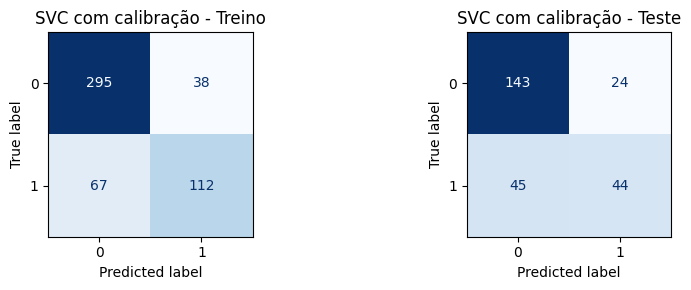

array([[143,  24],
       [ 45,  44]])

In [44]:
# Previsões no conjunto de treino
predict_svc(svc_calibrated_scaled, X_train_norm, y_train_norm, X_test_norm, y_test_norm)

Limiar (validação cruzada): 0.32653061224489793
F1-Score com limiar: 0.7258883248730964
F1-Scores: [0.5180897250361794, 0.5235294117647059, 0.5402124430955993, 0.5571205007824727, 0.5816993464052288, 0.5972696245733788, 0.6283662477558348, 0.655367231638418, 0.6692759295499021, 0.6774193548387096, 0.6721649484536083, 0.6853448275862069, 0.6962305986696231, 0.6993006993006993, 0.7016706443914081, 0.7156862745098039, 0.7258883248730964, 0.7120418848167539, 0.7115902964959568, 0.7094972067039106, 0.7122507122507122, 0.7146974063400576, 0.6943620178041543, 0.6826347305389222, 0.6625386996904025, 0.6369426751592356, 0.6387096774193548, 0.6360655737704918, 0.6305084745762712, 0.6164383561643836, 0.6041666666666666, 0.5915492957746479, 0.5474452554744526, 0.5298507462686567, 0.5038167938931297, 0.5, 0.48221343873517786, 0.4534412955465587, 0.425, 0.34210526315789475, 0.3153153153153153, 0.27102803738317754, 0.22115384615384615, 0.19704433497536947, 0.16161616161616163, 0.12371134020618557, 0.

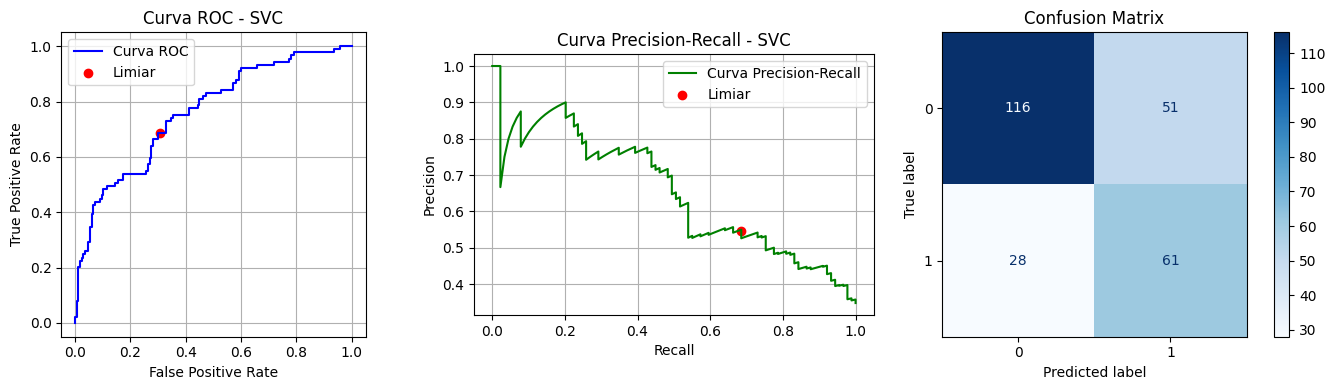

In [45]:
svc_calibrated_cm_thres_scaled, svc_fpr_scaled, svc_tpr_scaled, svc_roc_auc_scaled, svc_recall_scaled, svc_precision_scaled, svc_report_scaled = svc_with_threshold(X_train_norm, y_train_norm, X_test_norm, y_test_norm, cv, svc_best_params_scaled, svc_calibrated_scaled)

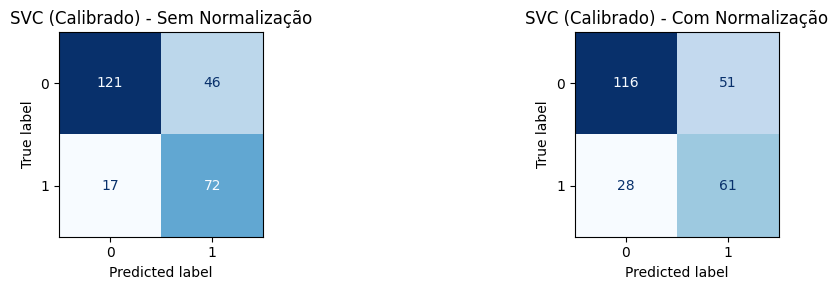

In [46]:
plot_CF(svc_calibrated_cm_thres,svc_calibrated_cm_thres_scaled, 'SVC (Calibrado) - Sem Normalização', 'SVC (Calibrado) - Com Normalização')

Comparando as duas matrizes acima, SVC calibrado sem normalização e SVC calibrado com normalização, conseguimos observar como a escala dos dados afeta a forma como o classificador define a fronteira de decisão.

Sem aplicar normalização, o modelo trabalha com a escala original das variáveis, o que pode fazer com que  que alguns atributos tenham mais importancia relativamente a outros, devido aos valores altos. Neste cenário, o classificador apresenta:
- Menos verdadeiros negativos
- Mais falsos positivos

Ou seja, o SVC sem normalização tende a ser mais conservador para a classe dos negativos, como é possivel ver pelo número de verdadeiros negativos.

Quando aplicamos normalização, todas as variáveis passam a na mesma escala, minimizando o impacto atributos com maior valor. Neste caso, o modelo torna-se ligeiramente mais conservador e estável:
- Aumentam os verdadeiros negativos
- Aumentam os falsos positivos
- Temos também uma aumento nos verdadeiros positivos e uma diminuição nos falsos negativo

Deste modo, o SVC com normalização passa a controlar melhor a fronteira associada à classe 0, embora que seja menos sensivel à classe 1. É o mesmo comportamento que vimos sem normalização, em que se ajustarmos o limiar para tentar encontrar um bom balanço entre o _recall_ e a _precision_, o modelo vai ter tendencia a classificar mais da classe 1 do que 0. 

### 3.3.3 - Treino com Pré-Processamento - Logistic Regression


Desempenho no conjunto de Treino
              precision    recall  f1-score   support

           0       0.82      0.89      0.85       333
           1       0.75      0.64      0.69       179

    accuracy                           0.80       512
   macro avg       0.78      0.76      0.77       512
weighted avg       0.80      0.80      0.79       512


Desempenho no conjunto de Teste
              precision    recall  f1-score   support

           0       0.77      0.87      0.81       167
           1       0.67      0.51      0.58        89

    accuracy                           0.74       256
   macro avg       0.72      0.69      0.70       256
weighted avg       0.73      0.74      0.73       256

Score dos dados de treino: 0.798828125
Score dos dados de teste: 0.7421875


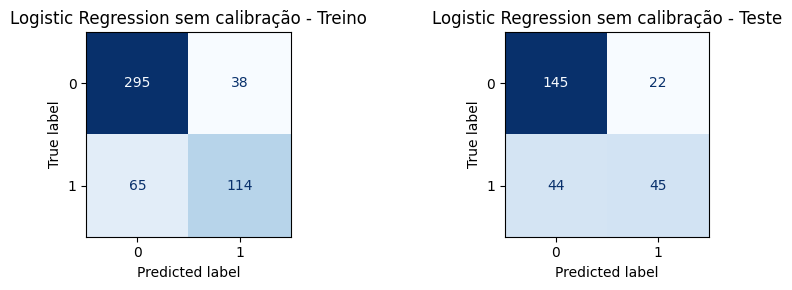

Fitting 5 folds for each of 310 candidates, totalling 1550 fits
Best parameters: {'C': np.float64(2.154434690031882), 'max_iter': 200, 'penalty': 'l2', 'solver': 'lbfgs'}

Desempenho no conjunto de Treino
              precision    recall  f1-score   support

           0       0.82      0.89      0.85       333
           1       0.75      0.64      0.69       179

    accuracy                           0.80       512
   macro avg       0.78      0.76      0.77       512
weighted avg       0.80      0.80      0.79       512


Desempenho no conjunto de Teste
              precision    recall  f1-score   support

           0       0.77      0.87      0.81       167
           1       0.67      0.51      0.58        89

    accuracy                           0.74       256
   macro avg       0.72      0.69      0.70       256
weighted avg       0.73      0.74      0.73       256

Score dos dados de treino: 0.798828125
Score dos dados de teste: 0.7421875
Best parameters: {'C': np.float64

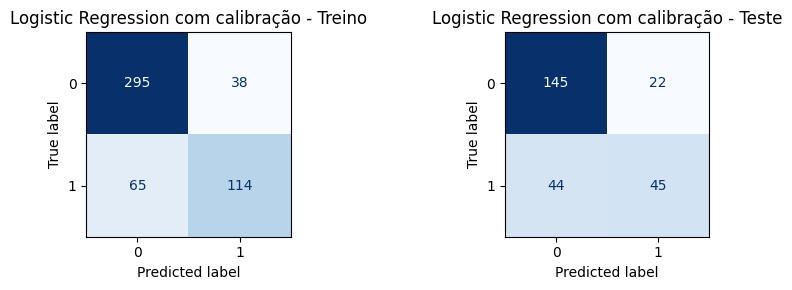

Limiar (validação cruzada): 0.3877551020408163
F1-Score com limiar: 0.7162534435261708
F1-Scores: [0.5180897250361794, 0.5329341317365269, 0.5553822152886115, 0.580327868852459, 0.6055363321799307, 0.6327272727272727, 0.6590909090909091, 0.67578125, 0.676056338028169, 0.6708333333333333, 0.6881720430107527, 0.6888888888888889, 0.6924829157175398, 0.6993006993006993, 0.6973365617433414, 0.7012345679012346, 0.7131782945736435, 0.7142857142857143, 0.7135135135135136, 0.7162534435261708, 0.713091922005571, 0.711864406779661, 0.6938775510204082, 0.6846846846846847, 0.6707692307692308, 0.6477987421383647, 0.6305732484076433, 0.6366559485530546, 0.6339869281045751, 0.6402640264026402, 0.6445182724252492, 0.6375838926174496, 0.5865724381625441, 0.5663082437275986, 0.5461254612546126, 0.5338345864661654, 0.5247148288973384, 0.5058365758754864, 0.48221343873517786, 0.45528455284552843, 0.4050632911392405, 0.3508771929824561, 0.3167420814479638, 0.28837209302325584, 0.23076923076923078, 0.1881188

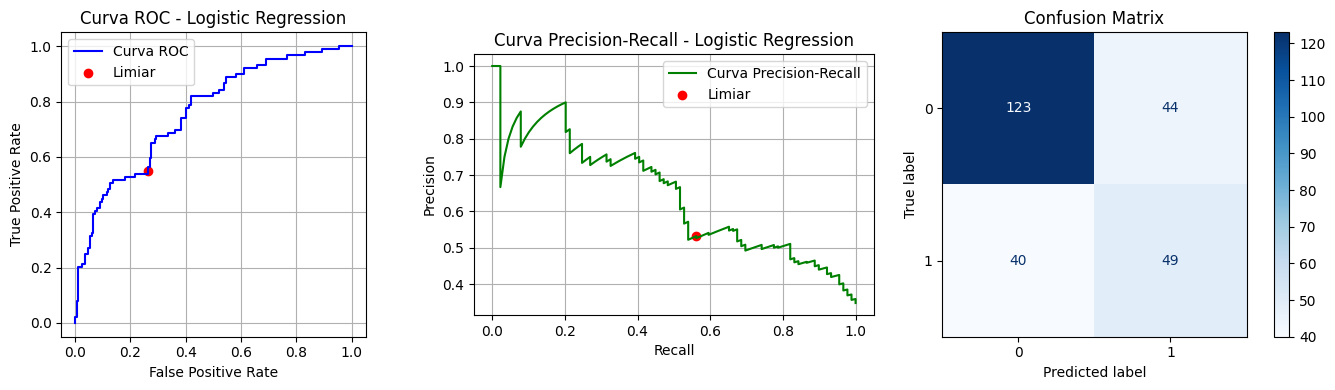

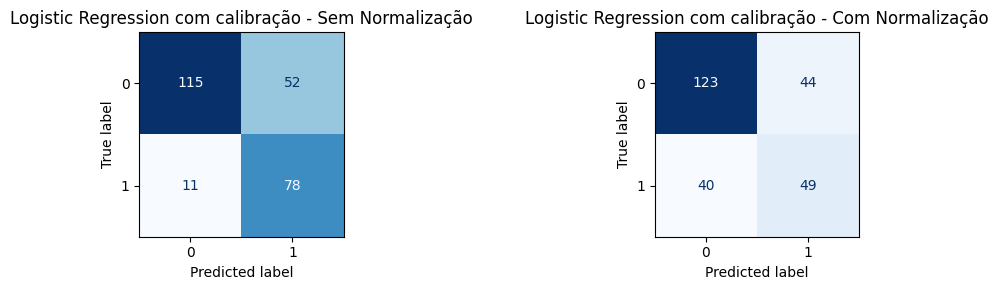

In [47]:
# create logistic regression with normalizaton
log_reg_norm = LogisticRegression(random_state=42, max_iter=1000).fit(X_train_norm, y_train_norm)

# Previsões no conjunto de treino
y_train_pred_log = log_reg_norm.predict(X_train_norm)
print("\nDesempenho no conjunto de Treino")
print(classification_report(y_train_norm, y_train_pred_log))
cm_train_log = confusion_matrix(y_train_norm, y_train_pred_log)

# Previsões no conjunto de teste
y_test_pred_log = log_reg_norm.predict(X_test_norm)
print("\nDesempenho no conjunto de Teste")
print(classification_report(y_test_norm, y_test_pred_log))
cm_test_log = confusion_matrix(y_test_norm, y_test_pred_log)
print('Score dos dados de treino:', log_reg_norm.score(X_train_norm, y_train_norm))
print('Score dos dados de teste:', log_reg_norm.score(X_test_norm, y_test_norm))

plot_confusion_matrices(cm_train_log, cm_test_log, 'Logistic Regression sem calibração')

# treinar modelo com grid search
logistic_calibrated_scaled, logistic_best_params_scaled = calibrate_logistic(param_grid_logistic, X_train_norm, y_train_norm, cv)
# Previsões no conjunto de treino
predict_logistic(logistic_calibrated_scaled, X_train_norm, y_train_norm, X_test_norm, y_test_norm, True)
logistic_calibrated_cm_thres_scaled, log_fpr_scaled, log_tpr_scaled, log_roc_auc_scaled, log_recall_scaled, log_precision_scaled, logistic_report_scaled = logistic_with_threshold(X_train_norm, y_train_norm, X_test_norm, y_test_norm, cv, logistic_best_params_scaled, logistic_calibrated_scaled)

# plot comparativo
plot_CF(logistic_calibrated_cm_thres,logistic_calibrated_cm_thres_scaled, 'Logistic Regression com calibração - Sem Normalização', 'Logistic Regression com calibração - Com Normalização')

### 3.3.4 - Treino com Pré-Processamento - Random Forest

In [48]:
rndforest_calibrated_scaled, rndForest_best_params_scaled = calibrate_rndForest(param_grid_RndForest, X_train_norm, y_train_norm, cv)

C:\Users\alice\AppData\Roaming\Python\Python313\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
3000 fits failed out of a total of 15000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3000 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\alice\AppData\Roaming\Python\Python313\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\alice\AppData\Roaming\Python\Python313\site-packages\sklearn\base.py", line 1358, in wrapper
    estimator._validate_params()
    ~~~~~~~~~~~~~~~~~~~~~~~~~~^^
  File "C:\Users\alice\AppData\Roaming\

{'bootstrap': True, 'class_weight': None, 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}



Desempenho no conjunto de Treino
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       333
           1       0.99      0.94      0.97       179

    accuracy                           0.98       512
   macro avg       0.98      0.97      0.98       512
weighted avg       0.98      0.98      0.98       512


Desempenho no conjunto de Teste
              precision    recall  f1-score   support

           0       0.79      0.86      0.82       167
           1       0.68      0.58      0.63        89

    accuracy                           0.76       256
   macro avg       0.74      0.72      0.73       256
weighted avg       0.76      0.76      0.76       256

Score dos dados de treino: 0.978515625
Score dos dados de teste: 0.76171875


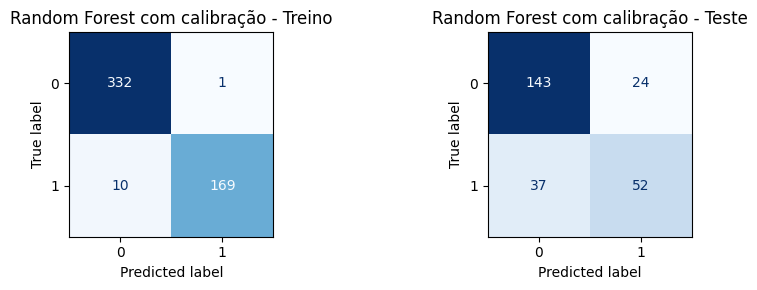

array([[143,  24],
       [ 37,  52]])

In [49]:
# Previsões no conjunto de treino
predict_rndForest(rndforest_calibrated_scaled, X_train_norm, y_train_norm, X_test_norm, y_test_norm)

Limiar (validação cruzada): 0.3469387755102041
F1-Score com limiar: 0.6908212560386473
F1-Scores: [0.5180897250361794, 0.5412844036697247, 0.5623003194888179, 0.5843071786310517, 0.5862068965517241, 0.6039076376554174, 0.6236162361623616, 0.6363636363636364, 0.6499032882011605, 0.6600790513833992, 0.6721649484536083, 0.6751592356687898, 0.6796536796536796, 0.68, 0.6817155756207675, 0.6820276497695853, 0.6885245901639344, 0.6908212560386473, 0.685, 0.6820512820512821, 0.6666666666666666, 0.6756756756756757, 0.6833333333333333, 0.672463768115942, 0.6646706586826348, 0.6666666666666666, 0.6285714285714286, 0.6153846153846154, 0.5894039735099338, 0.576271186440678, 0.5674740484429066, 0.5415162454873647, 0.5328467153284672, 0.5111111111111111, 0.47692307692307695, 0.4444444444444444, 0.39166666666666666, 0.34934497816593885, 0.2909090909090909, 0.25471698113207547, 0.1951219512195122, 0.12244897959183673, 0.08376963350785341, 0.043243243243243246, 0.02197802197802198, 0.011111111111111112,

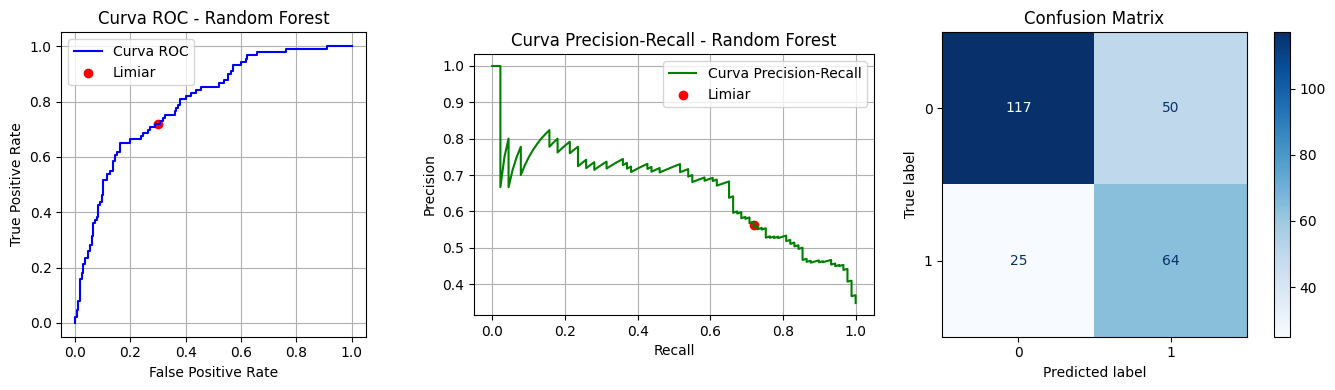

In [50]:
rndforest_calibrated_cm_thres_scaled, rf_fpr_scaled, rf_tpr_scaled, rf_roc_auc_scaled, rf_recall_scaled, rf_precision_scaled, rndforest_report_scaled = rndForest_with_threshold(X_train_norm, y_train_norm, X_test_norm, y_test_norm, cv, rndForest_best_params_scaled, rndforest_calibrated_scaled)

### 3.3.5 - Análise dos classificadores

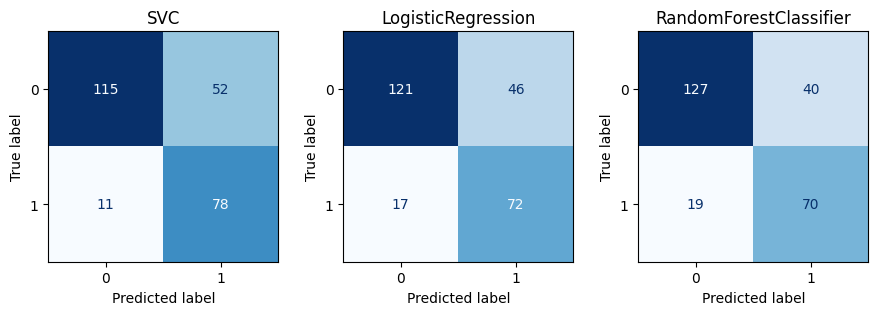

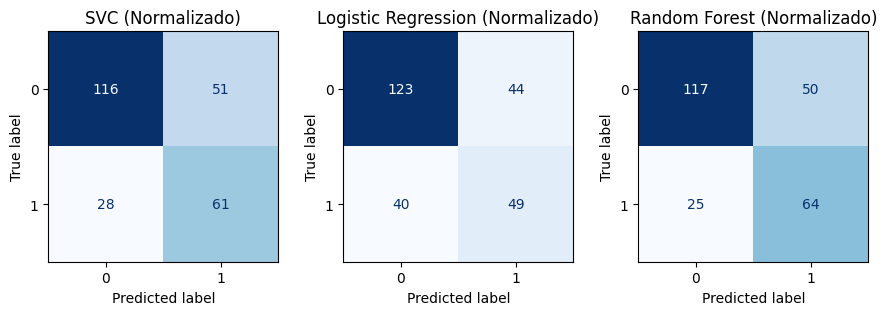

In [51]:
# Matrizes de confusão dos 3 classificadores normalizados
plot_cm_3(logistic_calibrated_cm_thres, svc_calibrated_cm_thres, cm_test_limiar,'SVC', 'LogisticRegression','RandomForestClassifier')
plot_cm_3(svc_calibrated_cm_thres_scaled, logistic_calibrated_cm_thres_scaled, rndforest_calibrated_cm_thres_scaled, 'SVC (Normalizado)', 'Logistic Regression (Normalizado)', 'Random Forest (Normalizado)')

Quando olhamos para as matrizes de confusão, conseguimos observar o impacto que normalização tem no desempenho dos classificadores. Antes da normalização, os três modelos têm  dificuldade geral em detectar a classe positiva, o que leva a uma quantidade de falsos negativos. Este comportamento pode ser devido à escala dos dados, com variaveis a terem mais impacto no desempenho do que outros.

Após aplicarmos a normalização, observamos que o desempenho melhorou nos modelos, sobretudo nos falsos negativos e aumentar as situações em que é identificada corretamente. No caso do SVC, essa diferença visivel. O modelo passa de um cenário em que falhava uma boa parte dos casos positivos para outro em que praticamente todos são captados. 

A Regressão Logística também beneficia do mesmo processo. Nota-se que ao uniformizar a escala das variáveis, o modelo consegue melhorar tanto na identificação correta dos positivos como na diminuição dos falsos negativos.

No Random Forest também observamos uma melhoria. Isto sugere que a normalização ajuda a evitar que certas variáveis com gamas de valores muito altas acabem por influenciar o modelo, fazendo as as árvores de decisão ficarem mais equilibradas e menos _biased_.

Em suma, entre todos os classificadores, o SVC parece ser o modelo que fica mais equilibrado. Fica com o melhor equilíbrio entre deteção correta da classe positiva e redução falsos negativos, acabando por ser o mais adequado para um cenário onde falhar um caso positivo é especialmente problemático, como acontece na deteção de diabetes.

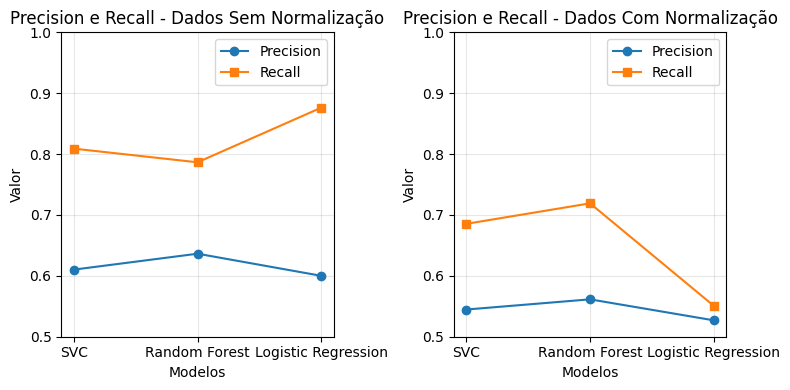

In [66]:
# Extrair Precision e Recall dos classification reports retornados pelas funções

# Sem normalização
svc_precision_no_norm = svc_report['1']['precision']
svc_recall_no_norm = svc_report['1']['recall']

rf_precision_no_norm = rndforest_report['1']['precision']
rf_recall_no_norm = rndforest_report['1']['recall']

log_precision_no_norm = logistic_report['1']['precision']
log_recall_no_norm = logistic_report['1']['recall']

# Com normalização
svc_precision_norm = svc_report_scaled['1']['precision']
svc_recall_norm = svc_report_scaled['1']['recall']

rf_precision_norm = rndforest_report_scaled['1']['precision']
rf_recall_norm = rndforest_report_scaled['1']['recall']

log_precision_norm = logistic_report_scaled['1']['precision']
log_recall_norm = logistic_report_scaled['1']['recall']

# Criar gráfico de pontos comparativo
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

models = ['SVC', 'Random Forest', 'Logistic Regression']
precision_no_norm = [svc_precision_no_norm, rf_precision_no_norm, log_precision_no_norm]
recall_no_norm = [svc_recall_no_norm, rf_recall_no_norm, log_recall_no_norm]
precision_norm = [svc_precision_norm, rf_precision_norm, log_precision_norm]
recall_norm = [svc_recall_norm, rf_recall_norm, log_recall_norm]

x = np.arange(len(models))

# Gráfico 1: Sem normalização
axes[0].plot(x, precision_no_norm, 'o-', label='Precision')
axes[0].plot(x, recall_no_norm, 's-', label='Recall')
axes[0].set_xlabel('Modelos')
axes[0].set_ylabel('Valor')
axes[0].set_title('Precision e Recall - Dados Sem Normalização')
axes[0].set_xticks(x)
axes[0].set_xticklabels(models)
axes[0].legend()
axes[0].set_ylim(0.5, 1)
axes[0].grid(True, alpha=0.3)

# Gráfico 2: Com normalização
axes[1].plot(x, precision_norm, 'o-', label='Precision')
axes[1].plot(x, recall_norm, 's-', label='Recall')
axes[1].set_xlabel('Modelos')
axes[1].set_ylabel('Valor')
axes[1].set_title('Precision e Recall - Dados Com Normalização')
axes[1].set_xticks(x)
axes[1].set_xticklabels(models)
axes[1].legend()
axes[1].set_ylim(0.5, 1)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

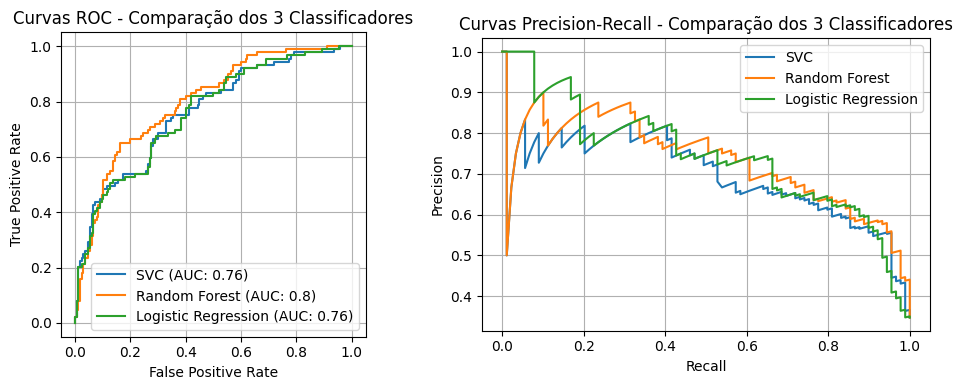

In [53]:
compare_classifiers(svc_fpr_scaled, svc_tpr_scaled, svc_roc_auc_scaled,rf_fpr_scaled, rf_tpr_scaled, rf_roc_auc_scaled, log_fpr_scaled, log_tpr_scaled, log_roc_auc_scaled)

Quando comparamos os valores de precision e recall antes e depois da normalização, observamos que nenhum dos três modelos melhora nessas métricas. Aliás, de forma consistente, todos sofrem uma queda no desempenho, ainda que por razões diferentes em cada caso.

No SVC, tanto a precision como o recall descem após a normalização. Isto é um pouco contraintuitivo, uma vez que este classificador costuma beneficiar bastante da homogeneização das escalas. No entanto, neste dataset em particular, essa normalização acaba por mover as fronteiras de decisão de forma a que o modelo se torne globalmente menos sensível aos casos positivos, o que se traduz numa redução clara do recall.

O Random Forest também sofre uma ligeira degradação do desempenho. Embora seja um modelo essencialmente insensível à escala das features, notamos que a normalização provoca uma queda tanto na precision como no recall. Ou seja, neste caso, a transformação não traz vantagem e até prejudica o comportamento do modelo.

Já na Regressão Logística, o impacto negativo é ainda mais marcado. Observa-se uma redução simultânea de precision e recall, o que sinaliza que o modelo perde capacidade de identificar corretamente positivos e ainda falha mais vezes ao distingui-los dos negativos.

Nas curvas ROC e Precision-Recall, este comportamento mantém-se: a normalização não traz benefícios visíveis e, para alguns classificadores, até desloca as curvas para regiões menos favoráveis do gráfico.


# 4 - Conclusões




# 5 - Bibliografia

- https://mariofilho.com/precisao-recall-e-f1-score-em-machine-learning/ 
- https://studyeasy.org/pt/course-articles/machine-leaning-articles-pt/auc-and-pr-curve-background-pt/#binary-classification-a-primer
- https://www.geeksforgeeks.org/machine-learning/how-to-choose-the-best-kernel-function-for-svms/
- https://stats.stackexchange.com/questions/279911/why-is-svm-sensitive-to-scaling-of-features